In [1008]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pymysql
import sqlalchemy

import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import json
import seaborn as sns
import pymysql
pymysql.install_as_MySQLdb()
import matplotlib
import requests
import json
matplotlib.rcParams['figure.figsize'] = (12, 8)
pd.set_option("max_columns", None)

# Loading and cleaning data

In [981]:
conn_string = 'mysql://{user}:{password}@{host}:{port}/{db}?charset={encoding}'.format(
    user='daily_screamer', 
    password='sF5pxbMLBg8=', 
    host = 'jsedocc7.scrc.nyu.edu', 
    port     = 3306, 
    encoding = 'utf8',
    db = 'daily_screamer'
)
engine = sqlalchemy.create_engine(conn_string)

stern = pd.read_sql("SELECT * FROM SternCE", engine).drop_duplicates()

In [984]:
df = pd.read_sql("SELECT * FROM CASCE", engine).drop_duplicates()
df.columns = df.columns[1:].insert(0, "course")

def parseCourseCode(df):
    df.columns = df.columns[1:].insert(0, "course")
    courseId = df.course.apply(lambda x: x.split(' ')[4].strip(' ()')).astype(int)
    courseCode = df.course.apply(lambda x: " ".join(x.split(' ')[:2]))
    courseSection = df.course.apply(lambda x: x.split(' ')[2])
    courseName = df.course.apply(lambda x: " ".join(x.split(' ')[6:]))

    df.insert(0, 'courseID',courseId)
    df.insert(1, 'courseCode', courseCode)
    df.insert(2, 'courseSection', courseSection)
    df.insert(3, 'courseName', courseName)
    #df.insert(4, 'classSize')
    df = df.drop('course', axis =1)

    temp = df['totalResponses'].str.rstrip('%').astype('float') / 100.0
    df['totalResponses'] = df['responseRate']
    df['responseRate'] = temp

    # convert to numeric
    df = df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
    return df


In [985]:
cas = parseCourseCode(df).reset_index(drop = True)
stern = parseCourseCode(stern).reset_index(drop = True)

In [551]:
cas.sample(5)

,courseID,courseCode,courseSection,courseName,instructor,totalResponses,responseRate,OverallEvaluationCourse.,objectivesClearlyStated,courseWellOrganized,...,increasedKnowledge,overallEvaluationInstructor.,conduciveToLearning.,helpfulFeedback,helpedMeLearn.,eencouragedParticipation.,facilitateDiscussion,openToQuestions,accessibleToStudents,inclusion
3227,9981,ENVST-UA 900,001,Environmental Studies Senior Seminar (Seminar),"Sonali McDermid, Erica Yuen",8,0.381,4.6,4.6,4.8,...,4.4,4.8,4.8,4.6,4.8,4.9,4.6,4.5,4.9,4.8
5195,9114,JOUR-UA 50,001,Investigating Journalism (Lecture),"Jda Gayle, Thomas Hengge, Phuong Hoa Nguyen, M...",48,0.440,3.8,4.0,3.9,...,4.0,4.0,4.0,3.0,3.8,4.5,4.1,4.2,4.3,4.2
4455,9747,ANTH-UA 80,001,Emerging Diseases (Seminar),"Andrew Burrell, Akaylia Rose, Amber Trujillo",20,0.247,4.2,4.4,4.3,...,4.2,4.2,4.2,4.2,4.1,3.6,3.6,4.4,4.2,4.3
2536,10054,CSCI-UA 476,001,Processing Big Data for Analytics Applications...,Ann Malavet,11,0.196,3.8,4.5,3.8,...,4.2,4.0,3.8,3.5,3.7,4.0,3.5,4.6,4.3,4.5
8521,20691,FYSEM-UA 719,001,"Daughters, Mothers, and Sisters: Women Who Sha...",Linda Almeida,8,0.533,4.3,4.3,4.4,...,4.5,4.6,4.5,4.3,4.4,4.6,4.5,4.8,4.6,4.6


In [391]:
stern.sample(5)

,courseID,courseCode,courseSection,courseName,instructor,totalResponses,responseRate,OverallEvaluationCourse,clearlyStatedObjectives,wellOrganized,intellectuallyStimulating,overallEvaluationInstructor,conduciveToLearning,providedHelpfulFeedback
614,11033,MGMT-UB 30,002,Negotiation & Consensus Building (Lecture),Elizabeth Howard,15,0.375,4.8,4.8,4.7,4.8,4.9,4.9,4.3
482,10790,MKTG-UB 64,001,Global Marketing Strategy (Lecture),Durairaj Maheswaran,13,0.361,4.5,4.5,4.6,4.3,4.5,4.5,4.3
177,10859,MULT-UB 100,007,Commerce and Culture (Lecture),Carol Newell,12,0.600,3.6,3.7,3.7,3.9,3.5,3.8,3.1
170,11113,MULT-UB 80,001,Foundations of FinTech (Lecture),"Yannis Bakos, Kathleen Derose",15,0.273,4.0,3.9,4.1,4.3,4.3,4.2,4.3
817,10816,ECON-UB 11,002,Economics of Global Business (Lecture),Joseph Foudy,60,0.343,3.8,4.3,4.3,4.2,4.0,4.0,3.5


# EDA

## CAS

In [552]:
Xcas = cas.iloc[:, 7:]
Xstern = stern.iloc[:, 7:]

In [553]:
Xcas.describe()

,OverallEvaluationCourse.,objectivesClearlyStated,courseWellOrganized,intellectuallyStimulating,EffectiveLearning,informative,challenging,increasedKnowledge,overallEvaluationInstructor.,conduciveToLearning.,helpfulFeedback,helpedMeLearn.,eencouragedParticipation.,facilitateDiscussion,openToQuestions,accessibleToStudents,inclusion
count,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000
mean,4.394104,4.485187,4.379011,4.479135,4.362894,4.480759,4.297083,4.556895,4.500734,4.491073,4.312951,4.402627,4.522199,4.346840,4.553367,4.513251,4.537354
std,0.504682,0.440911,0.540412,0.429311,0.514497,0.445266,0.399231,0.392089,0.502055,0.487189,0.587984,0.520625,0.482649,0.568507,0.438740,0.442288,0.421419
min,1.300000,1.500000,1.000000,1.900000,1.600000,1.700000,1.800000,1.800000,1.000000,1.100000,1.200000,1.300000,1.000000,1.400000,1.000000,1.500000,1.000000
25%,4.100000,4.300000,4.100000,4.300000,4.100000,4.300000,4.000000,4.400000,4.300000,4.300000,4.000000,4.100000,4.300000,4.000000,4.300000,4.300000,4.300000
50%,4.500000,4.600000,4.500000,4.600000,4.500000,4.600000,4.300000,4.600000,4.600000,4.600000,4.400000,4.500000,4.700000,4.500000,4.700000,4.600000,4.600000
75%,4.800000,4.800000,4.800000,4.800000,4.700000,4.800000,4.600000,4.800000,4.900000,4.800000,4.800000,4.800000,4.900000,4.800000,4.900000,4.800000,4.800000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [942]:
stern

,courseCode,instructor,totalResponses,responseRate,OverallEvaluationCourse,clearlyStatedObjectives,wellOrganized,intellectuallyStimulating,overallEvaluationInstructor,conduciveToLearning,providedHelpfulFeedback
0,ACCT-UB 1 001 (3103) - Prin of Financial Acct...,"Yiwei Dou, Xiaojing Meng",34.4%,11,4.3,4.5,4.6,4.4,4.6,4.5,4.5
1,FINC-UB 86 040 (1222) - Chinese Financial Mar...,Matthew Richardson,39.0%,16,4.8,4.8,4.4,4.8,4.7,4.7,4.5
2,MGMT-UB 1 040 (1221) - Management and Organiz...,Elinor Flynn,33.3%,9,4.8,4.8,4.9,4.8,4.8,4.9,4.6
3,MGMT-UB 1 041 (1224) - Management and Organiz...,Katia Meggiorin,32.1%,9,4.3,4.4,4.6,4.4,4.7,4.8,3.9
4,FINC-UB 86 040 (1114) - Chinese Financial Mar...,Matthew Richardson,57.7%,15,4.4,4.4,4.4,4.2,4.7,4.5,3.8
...,...,...,...,...,...,...,...,...,...,...,...
9189,STAT-UB 103 006 (10954) - Stats F/Bus Cntl Re...,Halina Frydman,56.9%,41,3.5,4.1,3.7,3.5,3.3,3.5,3.8
9190,MKTG-UB 1 040 (1194) - Intro to Marketing (L...,Carol Pluzinski,15.7%,8,4.6,5.0,4.8,4.5,4.9,4.8,4.5
9191,MKTG-UB 40 040 (1195) - Entertainment & Media...,Kenneth J Krushel,93.3%,14,4.7,4.6,4.8,4.4,4.9,4.8,4.5
9329,MKTG-UB 40 002 (11515) - Entertainment & Medi...,Kenneth J Krushel,56.1%,23,4.7,4.7,4.7,4.6,4.7,4.5,4.6


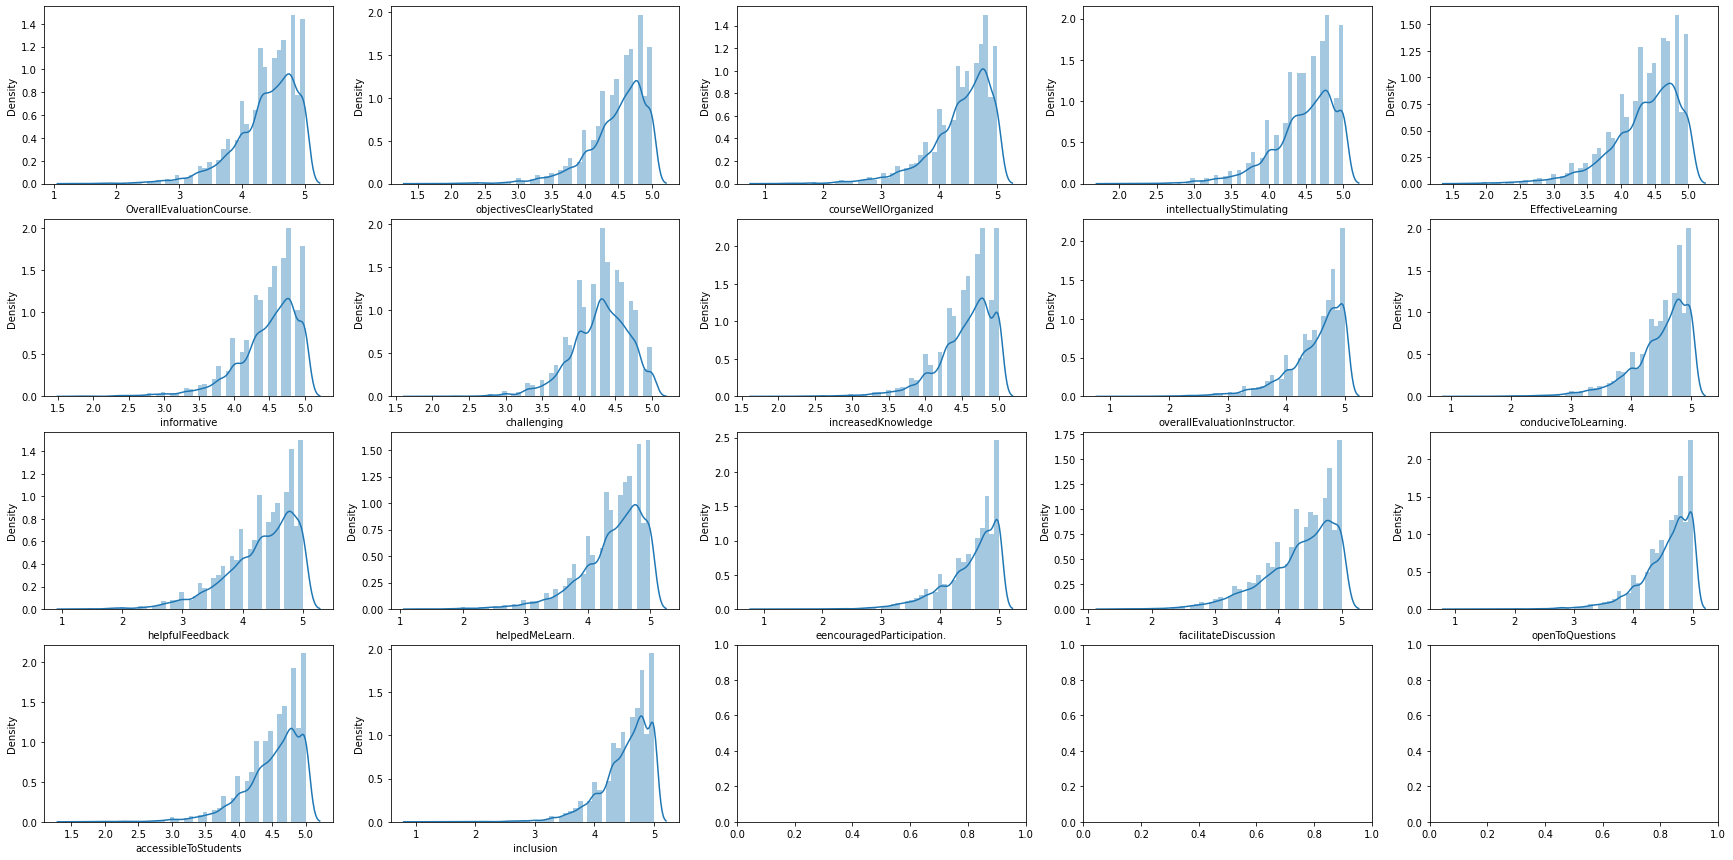

In [414]:
def plotDist(df, m, n):
    fig, axes = plt.subplots(m,n,figsize = (30,15))
    axes = axes.flat
    '''for kk in range(3):
        for jj in range(5):
            try:
                sns.distplot(df[df.columns[z]], ax = ax[kk, jj], hist = False, label = ii);
            except:
                pass
            z += 1'''
    for ii, ax in enumerate(axes):
        try:
            sns.distplot(df[df.columns[ii]], ax = ax, hist = True, label = df.columns[ii]);
        except:
            pass
plotDist(Xcas, 4, 5)

### nothing interesting so far. Look at corr matrix

In [400]:
Xcas.corr()

,OverallEvaluationCourse.,objectivesClearlyStated,courseWellOrganized,intellectuallyStimulating,EffectiveLearning,informative,challenging,increasedKnowledge,overallEvaluationInstructor.,conduciveToLearning.,helpfulFeedback,helpedMeLearn.,eencouragedParticipation.,facilitateDiscussion,openToQuestions,accessibleToStudents,inclusion
OverallEvaluationCourse.,1.000000,0.841580,0.818454,0.860350,0.923851,0.878580,0.238414,0.834625,0.904547,0.878596,0.791863,0.899872,0.729546,0.796183,0.756933,0.715749,0.810662
objectivesClearlyStated,0.841580,1.000000,0.875943,0.753108,0.821375,0.796848,0.267648,0.762561,0.796648,0.785912,0.738898,0.805519,0.628169,0.687752,0.670409,0.683677,0.723409
courseWellOrganized,0.818454,0.875943,1.000000,0.728545,0.796004,0.774016,0.276421,0.719494,0.781804,0.766613,0.722180,0.783329,0.600344,0.667733,0.640897,0.676140,0.694174
intellectuallyStimulating,0.860350,0.753108,0.728545,1.000000,0.877597,0.866067,0.393090,0.846273,0.805547,0.796448,0.693284,0.822065,0.662232,0.726635,0.686427,0.638874,0.734015
EffectiveLearning,0.923851,0.821375,0.796004,0.877597,1.000000,0.899832,0.274190,0.866174,0.865743,0.859823,0.773999,0.896034,0.718539,0.783428,0.728014,0.686844,0.792649
informative,0.878580,0.796848,0.774016,0.866067,0.899832,1.000000,0.307320,0.871015,0.837959,0.825811,0.703720,0.852311,0.655371,0.724337,0.702048,0.649987,0.754800
challenging,0.238414,0.267648,0.276421,0.393090,0.274190,0.307320,1.000000,0.336791,0.231913,0.229270,0.249829,0.256827,0.178148,0.211264,0.159901,0.248945,0.176274
increasedKnowledge,0.834625,0.762561,0.719494,0.846273,0.866174,0.871015,0.336791,1.000000,0.778675,0.766275,0.665879,0.802797,0.615475,0.662656,0.659136,0.618242,0.712067
overallEvaluationInstructor.,0.904547,0.796648,0.781804,0.805547,0.865743,0.837959,0.231913,0.778675,1.000000,0.935789,0.817776,0.937131,0.761070,0.828946,0.819470,0.748985,0.855525
conduciveToLearning.,0.878596,0.785912,0.766613,0.796448,0.859823,0.825811,0.229270,0.766275,0.935789,1.000000,0.813360,0.929316,0.790925,0.853561,0.845647,0.747789,0.877795


<AxesSubplot:>

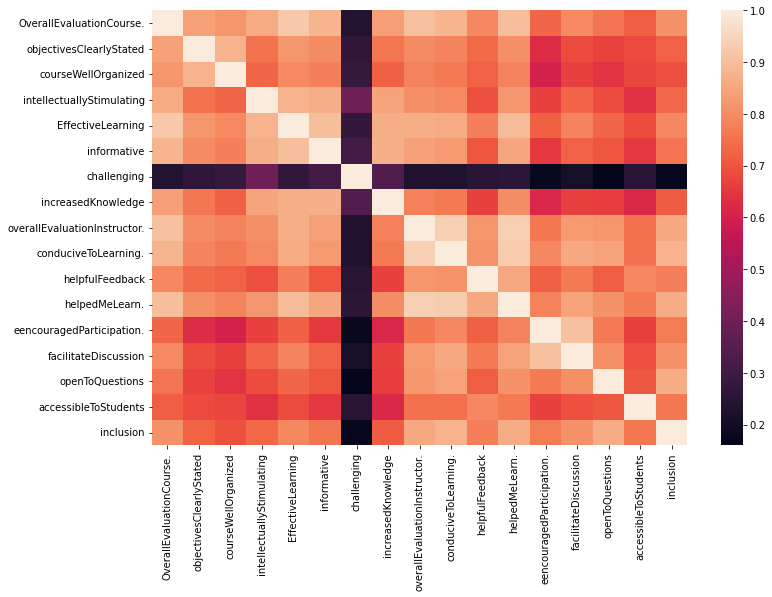

In [401]:
sns.heatmap(Xcas.corr())
# correlations are generaly very high as expected
# overallEvalOfCourse vs. instructor and effectiveLearning are espectially high, 0.905 and 0.924

# challenging has very low correlatio. Is it because the more challenging a class is, the lower student might rate them?
# or does it suggest the difficulty of a class does not relate to other attributes?


<AxesSubplot:xlabel='OverallEvaluationCourse.', ylabel='overallEvaluationInstructor.'>

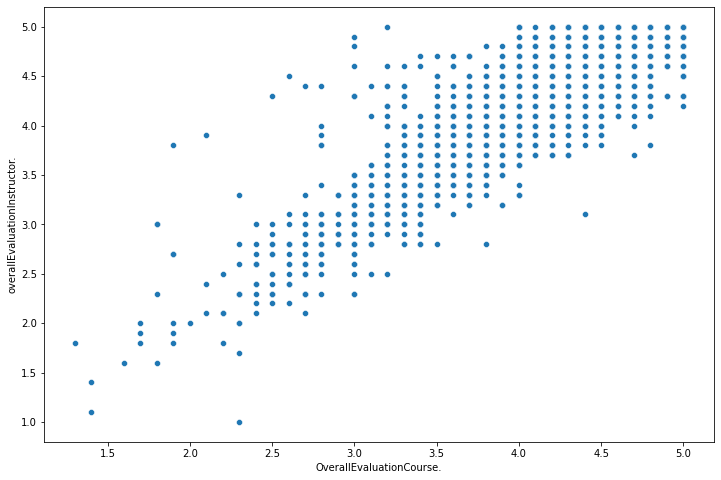

In [408]:
sns.scatterplot(Xcas['OverallEvaluationCourse.'], Xcas['overallEvaluationInstructor.'])

<AxesSubplot:xlabel='OverallEvaluationCourse.', ylabel='EffectiveLearning'>

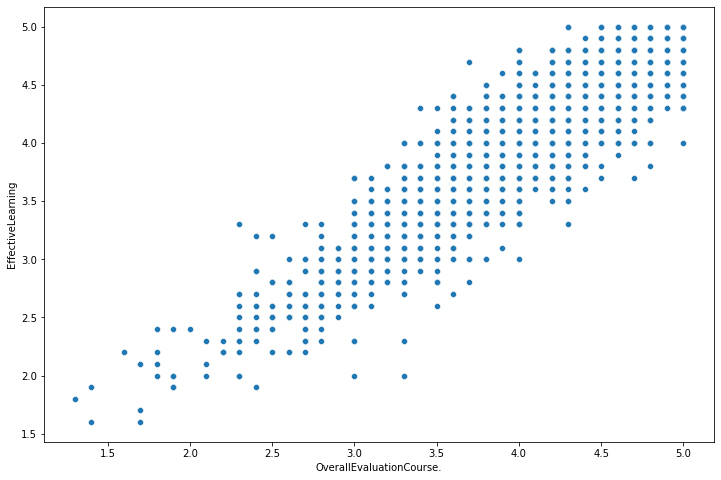

In [409]:
sns.scatterplot(Xcas['OverallEvaluationCourse.'], Xcas['EffectiveLearning'])

### Within each distinct class identified by courseCode, how does the distributino look like?

In [684]:
casGroupCourse = cas.groupby('courseCode')
casG = casGroupCourse.mean()
Xgcas = casG.iloc[:, 3:]

In [685]:
Xgcas.describe()

,OverallEvaluationCourse.,objectivesClearlyStated,courseWellOrganized,intellectuallyStimulating,EffectiveLearning,informative,challenging,increasedKnowledge,overallEvaluationInstructor.,conduciveToLearning.,helpfulFeedback,helpedMeLearn.,eencouragedParticipation.,facilitateDiscussion,openToQuestions,accessibleToStudents,inclusion
count,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000
mean,4.418371,4.474212,4.368069,4.531672,4.390238,4.534615,4.288141,4.613388,4.526869,4.504205,4.314724,4.423827,4.534422,4.354943,4.575240,4.523249,4.556892
std,0.412791,0.378390,0.453721,0.342671,0.415322,0.344419,0.352665,0.309163,0.398790,0.394641,0.493500,0.415865,0.401175,0.478930,0.353982,0.370964,0.336490
min,1.300000,1.500000,1.300000,2.000000,1.800000,1.800000,2.200000,2.000000,1.600000,1.700000,1.300000,1.500000,2.066667,1.800000,2.266667,2.000000,2.100000
25%,4.200000,4.300000,4.150000,4.350000,4.177201,4.388889,4.100000,4.479349,4.350000,4.300000,4.036905,4.200000,4.300000,4.085119,4.400000,4.348244,4.400000
50%,4.500000,4.546061,4.450000,4.600000,4.475000,4.600000,4.300000,4.677350,4.600000,4.600000,4.400000,4.500000,4.627619,4.450000,4.650000,4.600000,4.605410
75%,4.700000,4.740000,4.700000,4.783929,4.700000,4.800000,4.500000,4.800000,4.800000,4.800000,4.700000,4.700000,4.811458,4.700000,4.800000,4.800000,4.800000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


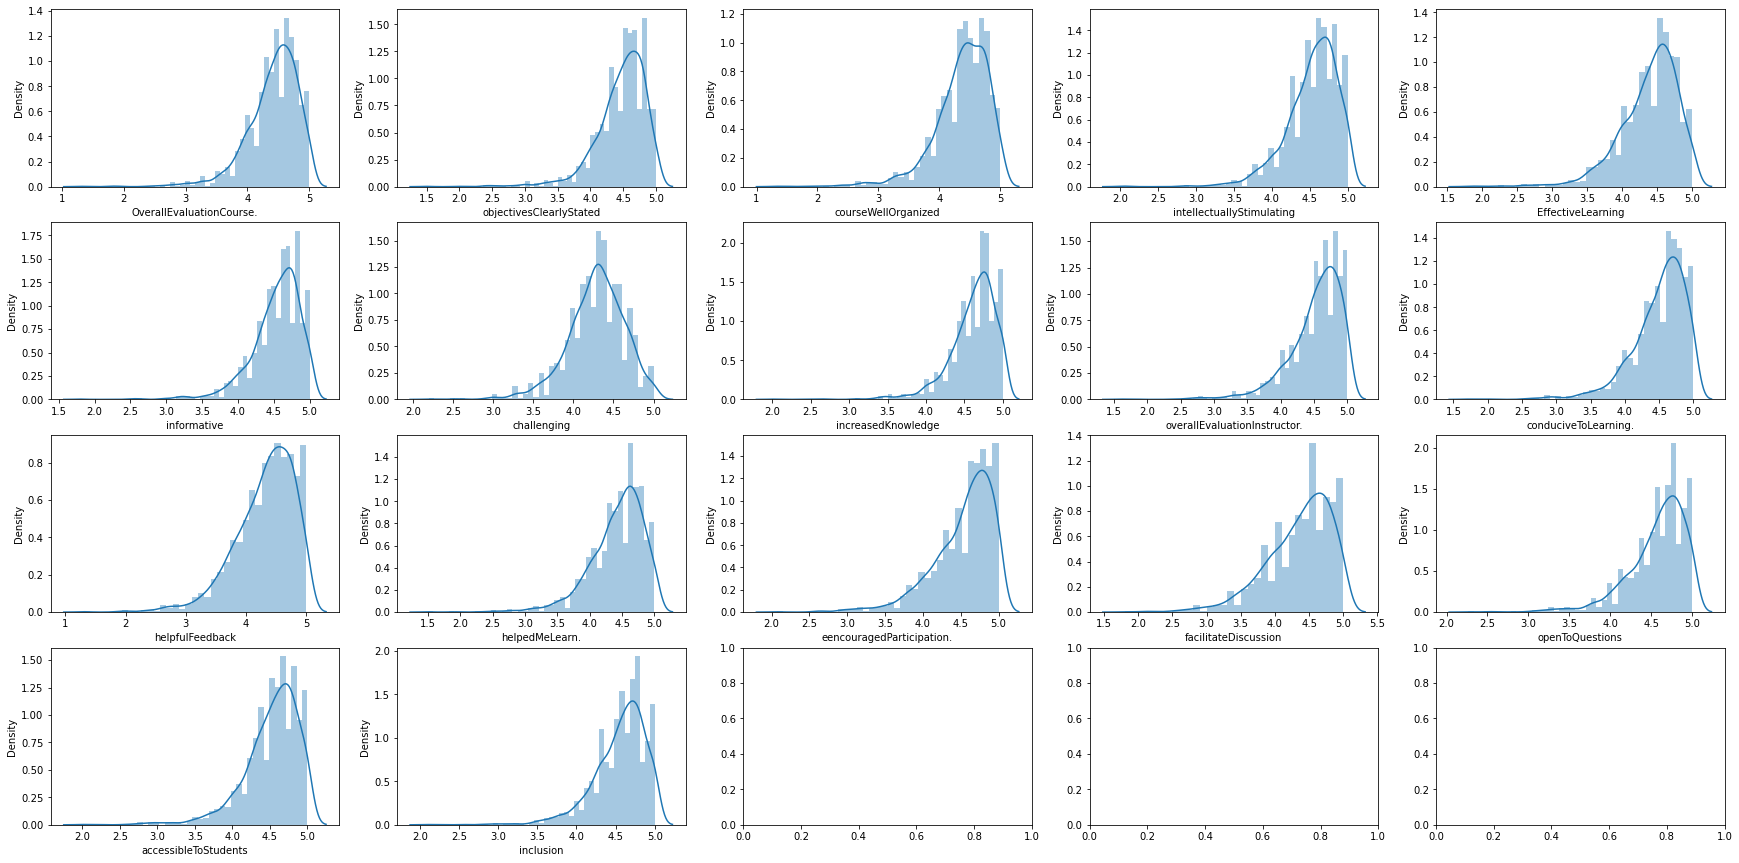

In [682]:
plotDist(Xgcas, 4, 5)

In [689]:
Xgcas.corr()
# after grouping by course, we find that the overall evalutation of the course is highly correlated with effective learning, instructor, and help me learn

,OverallEvaluationCourse.,objectivesClearlyStated,courseWellOrganized,intellectuallyStimulating,EffectiveLearning,informative,challenging,increasedKnowledge,overallEvaluationInstructor.,conduciveToLearning.,helpfulFeedback,helpedMeLearn.,eencouragedParticipation.,facilitateDiscussion,openToQuestions,accessibleToStudents,inclusion
OverallEvaluationCourse.,1.000000,0.839157,0.816564,0.866265,0.928784,0.881316,0.323825,0.860199,0.914618,0.892990,0.800109,0.912794,0.723297,0.807084,0.757052,0.733226,0.807939
objectivesClearlyStated,0.839157,1.000000,0.888587,0.743995,0.819478,0.803846,0.365014,0.782563,0.798462,0.785156,0.738151,0.802055,0.588553,0.682539,0.640220,0.693821,0.694051
courseWellOrganized,0.816564,0.888587,1.000000,0.711993,0.790162,0.783279,0.349584,0.751373,0.782991,0.770699,0.736228,0.782286,0.582589,0.678823,0.611665,0.687696,0.668099
intellectuallyStimulating,0.866265,0.743995,0.711993,1.000000,0.880433,0.874115,0.490402,0.855097,0.809409,0.802675,0.692224,0.830326,0.655806,0.732754,0.674244,0.655404,0.729460
EffectiveLearning,0.928784,0.819478,0.790162,0.880433,1.000000,0.899843,0.352216,0.875181,0.872766,0.872857,0.775635,0.901758,0.698201,0.786228,0.721995,0.713973,0.789068
informative,0.881316,0.803846,0.783279,0.874115,0.899843,1.000000,0.395483,0.889233,0.830424,0.820053,0.711488,0.854343,0.616124,0.703651,0.674781,0.661944,0.735764
challenging,0.323825,0.365014,0.349584,0.490402,0.352216,0.395483,1.000000,0.398286,0.302159,0.299997,0.318477,0.322878,0.214063,0.261362,0.184454,0.301492,0.219199
increasedKnowledge,0.860199,0.782563,0.751373,0.855097,0.875181,0.889233,0.398286,1.000000,0.801461,0.781997,0.687408,0.819438,0.597811,0.674139,0.646602,0.646845,0.718057
overallEvaluationInstructor.,0.914618,0.798462,0.782991,0.809409,0.872766,0.830424,0.302159,0.801461,1.000000,0.940893,0.829905,0.938935,0.742992,0.827938,0.814563,0.774781,0.847181
conduciveToLearning.,0.892990,0.785156,0.770699,0.802675,0.872857,0.820053,0.299997,0.781997,0.940893,1.000000,0.824034,0.942090,0.774558,0.853675,0.845656,0.771467,0.868960


<AxesSubplot:>

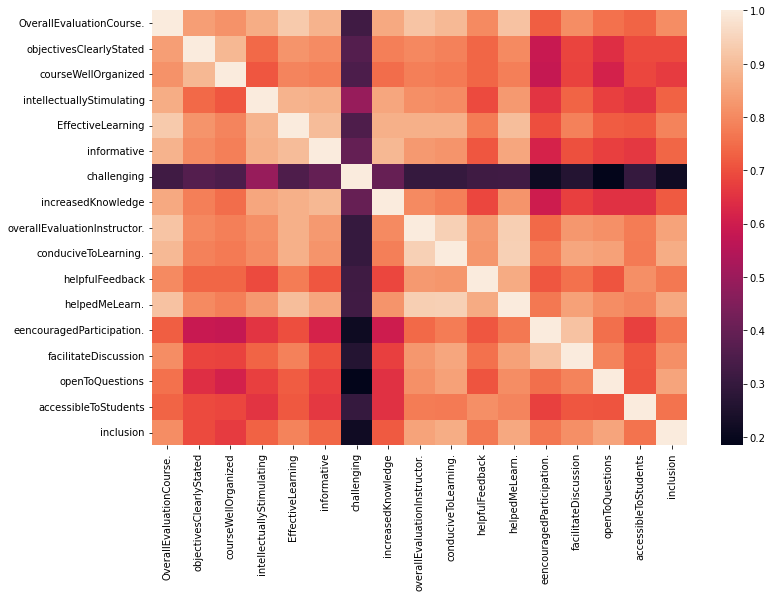

In [693]:
sns.heatmap(Xgcas.corr())

## Stern

In [418]:
Xstern.describe()
# although stern has a smaller sample size, the standard deviaiton for the ratings are smaller

,OverallEvaluationCourse,clearlyStatedObjectives,wellOrganized,intellectuallyStimulating,overallEvaluationInstructor,conduciveToLearning,providedHelpfulFeedback
count,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000
mean,4.323077,4.436935,4.370405,4.361538,4.433588,4.433823,4.138873
std,0.446808,0.396301,0.484003,0.426054,0.444115,0.431345,0.518487
min,2.100000,2.100000,1.700000,2.400000,2.100000,2.100000,2.000000
25%,4.100000,4.300000,4.100000,4.100000,4.200000,4.200000,3.800000
50%,4.400000,4.500000,4.500000,4.400000,4.500000,4.500000,4.200000
75%,4.700000,4.700000,4.700000,4.700000,4.800000,4.800000,4.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


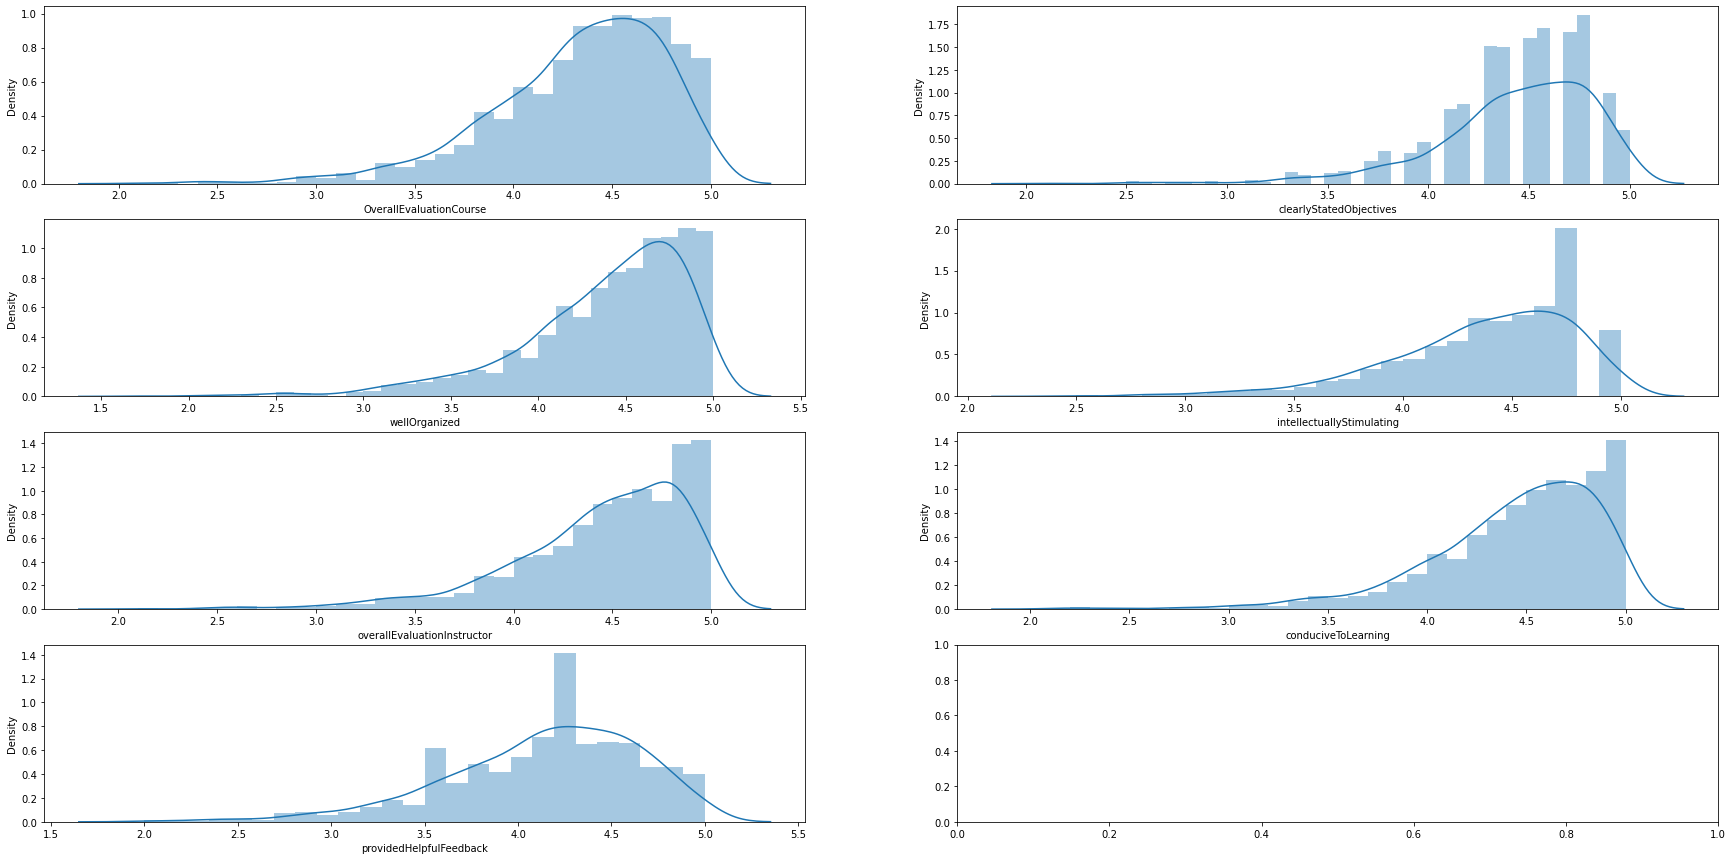

In [417]:
plotDist(Xstern, 4,2)

In [420]:
Xstern.corr()

,OverallEvaluationCourse,clearlyStatedObjectives,wellOrganized,intellectuallyStimulating,overallEvaluationInstructor,conduciveToLearning,providedHelpfulFeedback
OverallEvaluationCourse,1.000000,0.839384,0.832354,0.860590,0.922973,0.881371,0.790358
clearlyStatedObjectives,0.839384,1.000000,0.880444,0.740214,0.799604,0.780777,0.748438
wellOrganized,0.832354,0.880444,1.000000,0.739237,0.803480,0.780920,0.725797
intellectuallyStimulating,0.860590,0.740214,0.739237,1.000000,0.812738,0.792121,0.694871
overallEvaluationInstructor,0.922973,0.799604,0.803480,0.812738,1.000000,0.925590,0.783629
conduciveToLearning,0.881371,0.780777,0.780920,0.792121,0.925590,1.000000,0.765567
providedHelpfulFeedback,0.790358,0.748438,0.725797,0.694871,0.783629,0.765567,1.000000


<AxesSubplot:>

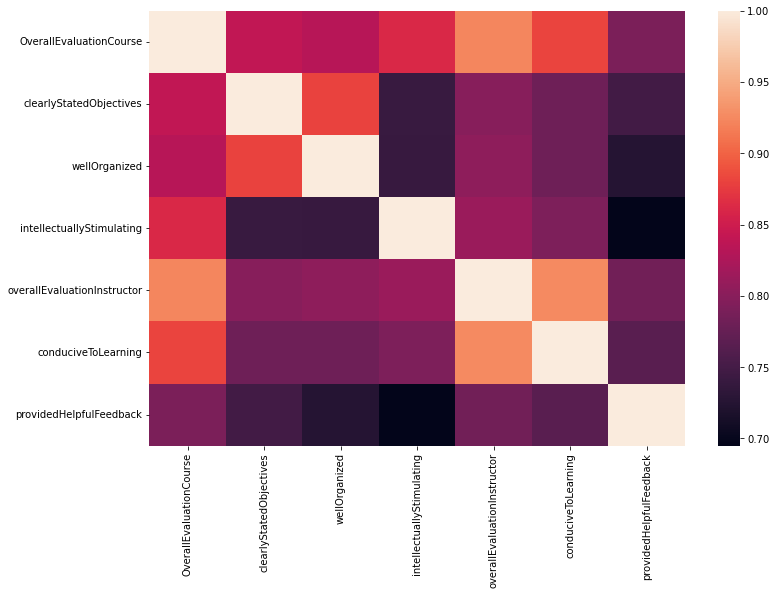

In [421]:
sns.heatmap(Xstern.corr())

### Group by course

In [687]:
sternGroupCourse = stern.groupby('courseCode')
sternG = sternGroupCourse.mean()
Xgstern = sternG.iloc[:, 3:]
Xgstern.describe()

,OverallEvaluationCourse,clearlyStatedObjectives,wellOrganized,intellectuallyStimulating,overallEvaluationInstructor,conduciveToLearning,providedHelpfulFeedback
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,4.346836,4.408762,4.313405,4.410966,4.463573,4.454955,4.154133
std,0.370195,0.346768,0.433681,0.324700,0.340710,0.331913,0.434608
min,2.666667,2.566667,2.100000,2.900000,2.866667,3.200000,2.400000
25%,4.200000,4.300000,4.140000,4.216667,4.300000,4.309091,3.966667
50%,4.400000,4.463636,4.400000,4.450000,4.500000,4.478571,4.200000
75%,4.600000,4.616667,4.566667,4.633333,4.700000,4.700000,4.400000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


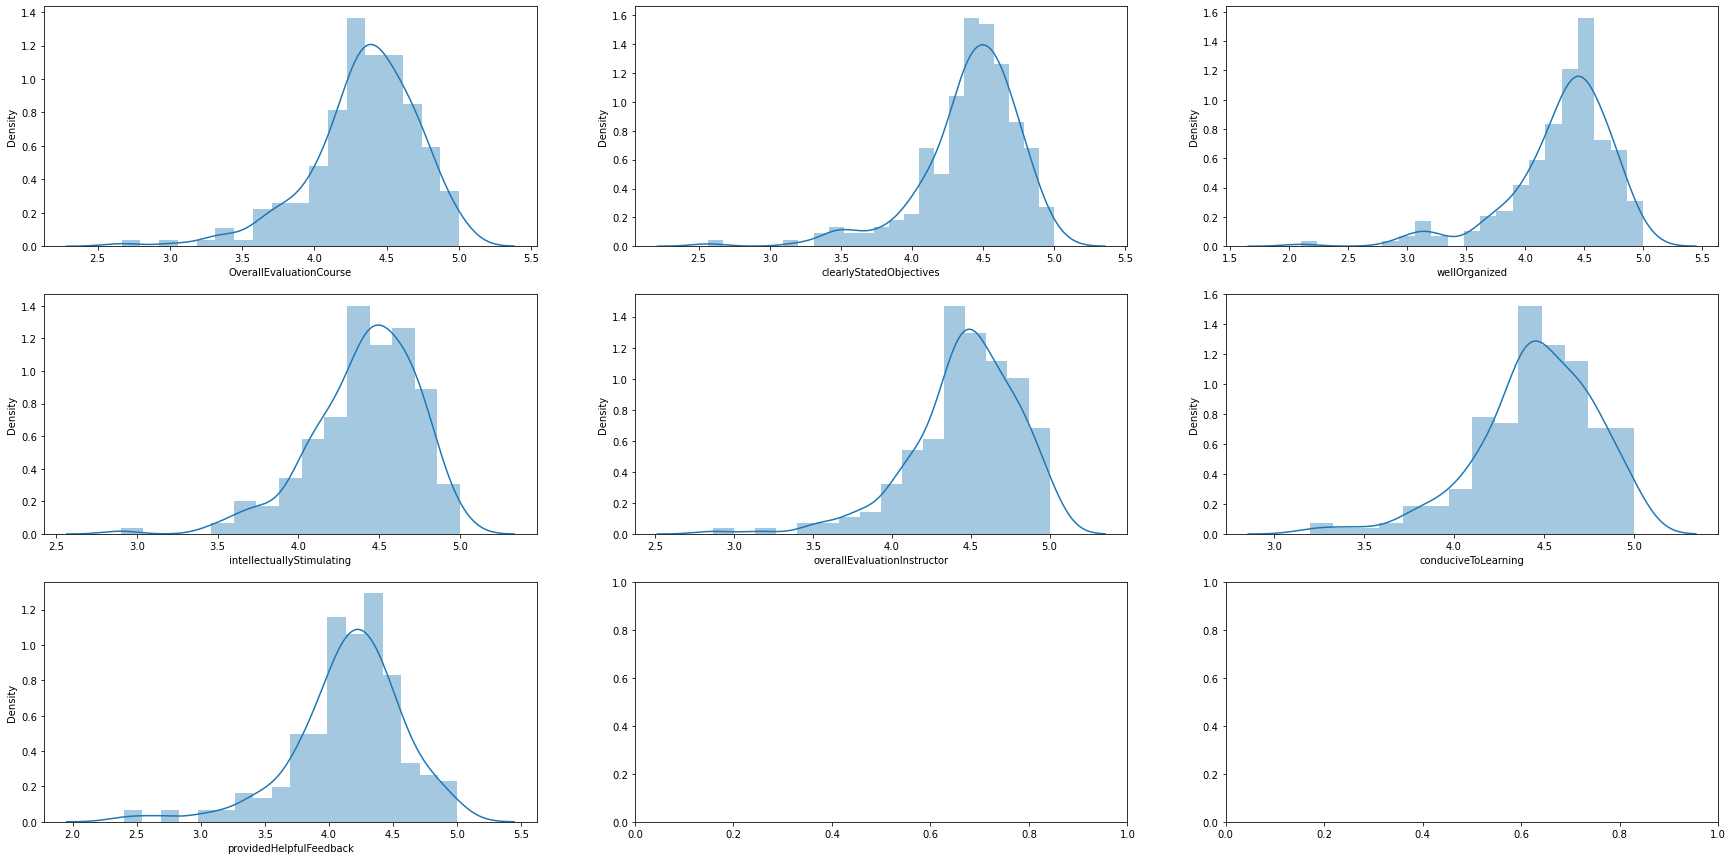

In [691]:
plotDist(Xgstern, 3, 3)

In [688]:
Xgstern.corr()
# after grouping by course, the overall evaluation of the course is very very highly correlated with the quality of the instructor.

,OverallEvaluationCourse,clearlyStatedObjectives,wellOrganized,intellectuallyStimulating,overallEvaluationInstructor,conduciveToLearning,providedHelpfulFeedback
OverallEvaluationCourse,1.000000,0.871970,0.850822,0.872393,0.943232,0.897522,0.814370
clearlyStatedObjectives,0.871970,1.000000,0.917327,0.749462,0.811607,0.777008,0.780906
wellOrganized,0.850822,0.917327,1.000000,0.721842,0.796024,0.753367,0.760431
intellectuallyStimulating,0.872393,0.749462,0.721842,1.000000,0.849662,0.819258,0.722623
overallEvaluationInstructor,0.943232,0.811607,0.796024,0.849662,1.000000,0.937700,0.793272
conduciveToLearning,0.897522,0.777008,0.753367,0.819258,0.937700,1.000000,0.766715
providedHelpfulFeedback,0.814370,0.780906,0.760431,0.722623,0.793272,0.766715,1.000000


<AxesSubplot:>

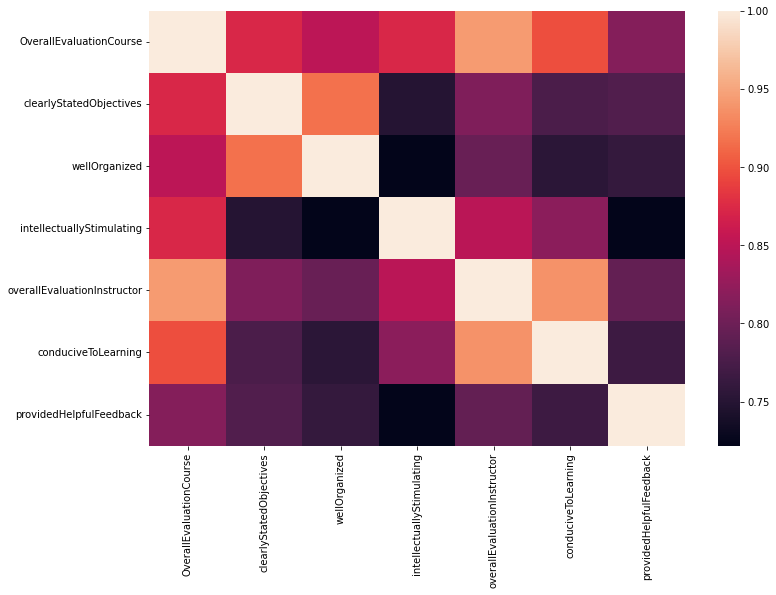

In [692]:
sns.heatmap(Xgstern.corr())

# PCA

In [1139]:
def performPCA(data, n = 2, loadingsPlot = True, screePlot = True, threshold = 0.8, scatter = True):
    Xz = StandardScaler().fit_transform(data)
    pca = PCA().fit(Xz)
    loadings = pca.components_
    casPCA = pca.transform(Xz)
    temp = list(range(len(Xz[0])))
    print(pca.explained_variance_ratio_.cumsum())
    if screePlot:
        fig, ax = plt.subplots(1, 2, figsize = (20, 8))
        
        ax[0].bar(temp, pca.explained_variance_)
        ax[0].plot([0,len(temp)], [1,1], color = 'orange')
        ax[0].set_title("Eigen Values of Each PC")
        ax[1].plot(pca.explained_variance_ratio_.cumsum())
        ax[1].plot([0, len(temp)], [threshold, threshold])
        ax[1].set_title("Cumulative Sum of Explained Variance")
    if loadingsPlot:
        for ii in range(n):
            plt.figure(figsize = (15, 8))
            plt.bar(temp, loadings[ii]*-1)
            plt.xticks(temp, data.columns, rotation = 45);
            plt.title('PC%d' %ii)
            #print(pd.Series(loadings[:, ii], index = features).sort_values(ascending=False, key = abs)[:3])
            print()

    if scatter:
        plt.figure()
        plt.scatter(-casPCA[:, 0], -casPCA[:, 1], s = 2)
    return casPCA, pca

[0.75115004 0.81529577 0.85836859 0.88887938 0.90906488 0.92606233
 0.9398793  0.94948232 0.95798394 0.96541237 0.97238502 0.97886101
 0.98451603 0.98927298 0.99363725 0.99721531 1.        ]




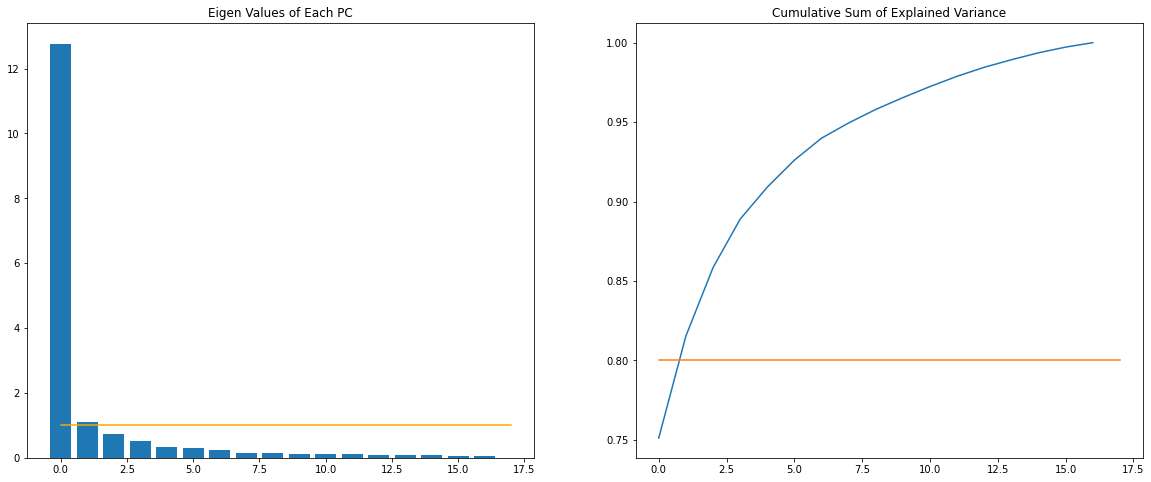

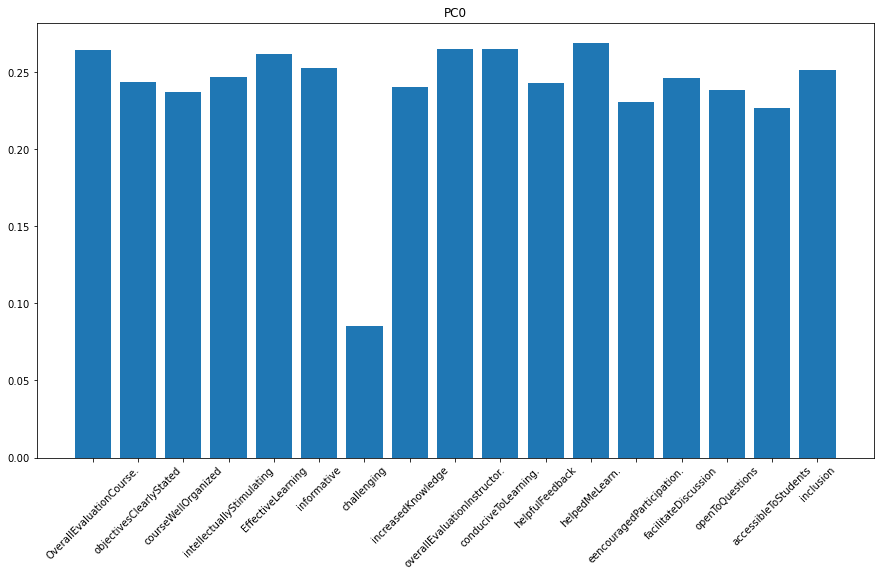

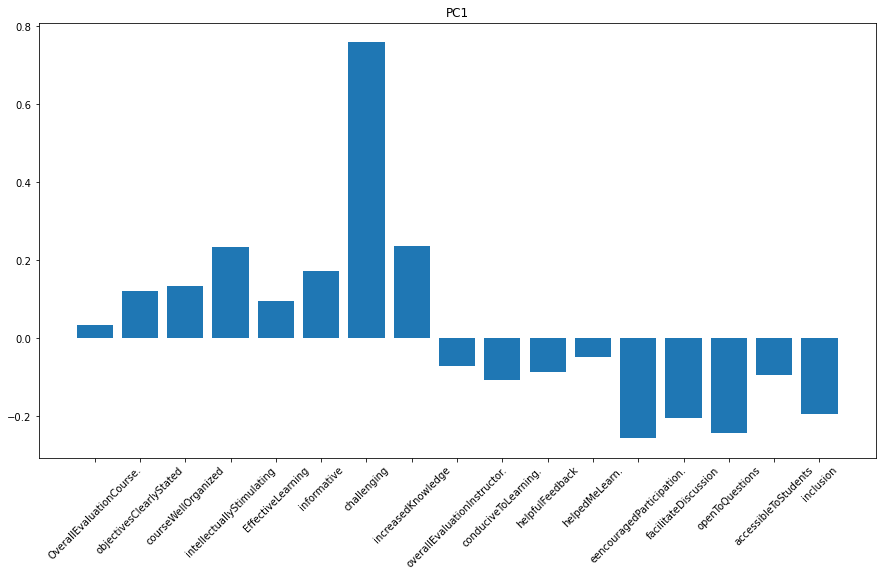

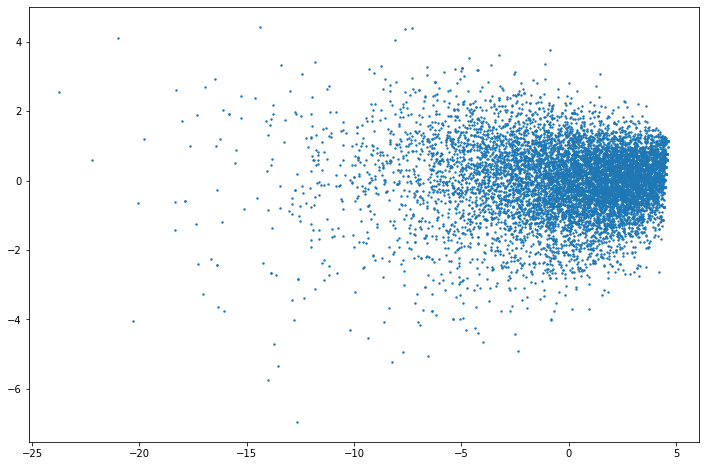

In [1140]:
casPCA, _ = performPCA(Xcas, n = 2);

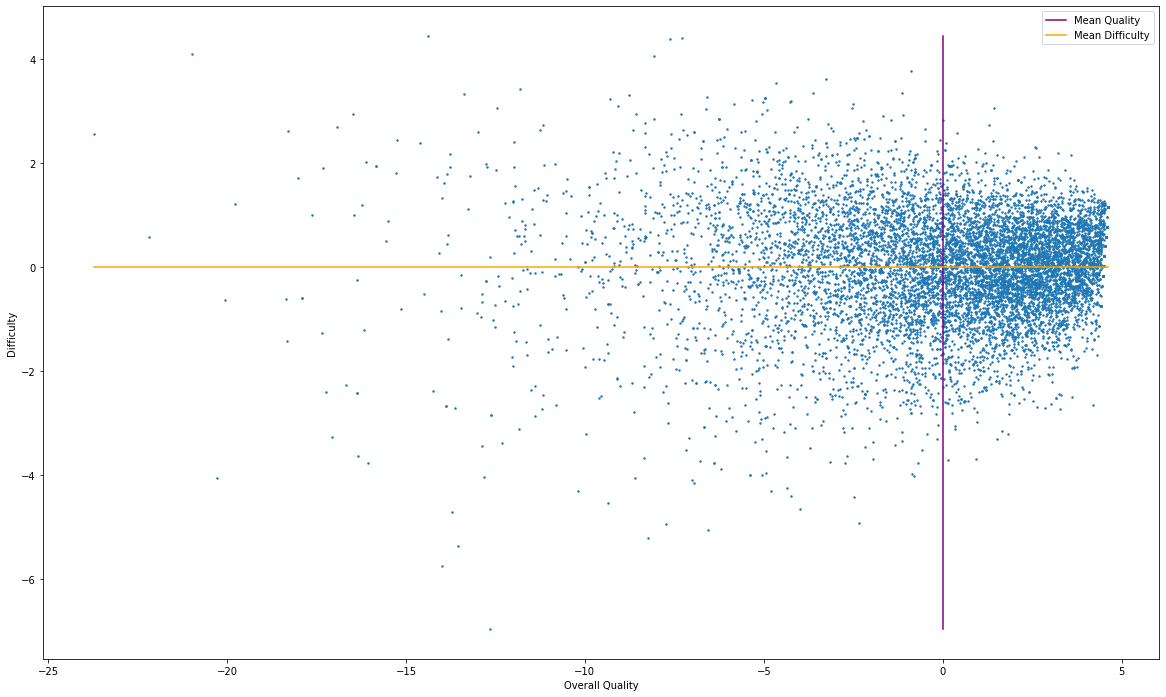

In [1164]:
plt.figure(figsize=(20, 12))
plt.scatter(cas.qualityPCA, cas.difficultyPCA, s = 2)
plt.plot([cas.qualityPCA.mean()] * 2, [cas.difficultyPCA.min(), cas.difficultyPCA.max()], c = 'purple', label = 'Mean Quality')
plt.plot([cas.qualityPCA.min(), cas.qualityPCA.max()], [cas.difficultyPCA.mean()]*2, c = 'orange', label = 'Mean Difficulty')
plt.xlabel("Overall Quality")
plt.ylabel("Difficulty")
plt.legend()

In [1167]:
cas[cas.courseName.str.contains("Ordinary")]

,courseID,courseCode,courseSection,courseName,instructor,totalResponses,responseRate,OverallEvaluationCourse.,objectivesClearlyStated,courseWellOrganized,intellectuallyStimulating,EffectiveLearning,informative,challenging,increasedKnowledge,overallEvaluationInstructor.,conduciveToLearning.,helpfulFeedback,helpedMeLearn.,eencouragedParticipation.,facilitateDiscussion,openToQuestions,accessibleToStudents,inclusion,qualityPCA,difficultyPCA,sampleSize
157,2939,MATH-UA 262,001,Ordinary Diff Equations (Lecture),Jose Diaz-Alban,6,0.171,3.5,3.8,3.5,3.8,3.3,3.8,4.2,4.0,3.5,3.7,3.3,3.5,4.0,3.5,4.2,4.2,4.2,-5.923596,-0.274397,35.087719
1334,8262,MATH-UA 262,001,Ordinary Diff Equations (Lecture),Dimitrios Giannakis,19,0.500,4.2,4.2,4.3,4.4,4.1,4.1,4.5,4.5,4.1,4.2,3.8,4.1,3.5,3.3,4.2,4.5,4.4,-2.640732,1.405122,38.000000
1335,9035,MATH-UA 262,003,Ordinary Diff Equations (Lecture),Alexander Mogilner,9,0.225,4.4,4.9,4.7,4.4,4.4,4.6,3.4,4.7,4.7,4.8,4.3,4.6,4.1,4.1,4.3,4.3,4.7,0.220522,-1.105648,40.000000
3915,8392,MATH-UA 262,001,Ordinary Diff Equations (Lecture),Edwin Gerber,7,0.226,4.9,4.9,4.9,4.9,4.7,4.9,4.9,4.7,5.0,5.0,4.9,4.9,4.7,4.4,5.0,5.0,4.7,3.326419,1.112184,30.973451
3916,8886,MATH-UA 262,003,Ordinary Diff Equations (Lecture),Zhuocheng Xiao,15,0.405,4.5,4.9,4.4,4.7,4.8,4.8,4.6,4.9,4.7,4.9,4.7,4.7,4.9,4.8,4.9,4.8,4.9,2.668040,0.248557,37.037037
5293,9293,MATH-UA 262,001,Ordinary Diff Equations (Lecture),Edwin Gerber,10,0.294,4.2,4.2,4.5,4.3,3.9,4.3,4.4,4.6,4.2,4.3,4.3,4.2,4.1,3.9,4.4,4.3,4.3,-1.700567,0.636647,34.013605
5294,10147,MATH-UA 262,003,Ordinary Diff Equations (Lecture),Eric Vanden-Eijnden,11,0.344,4.5,4.6,4.3,4.6,4.6,4.7,4.4,4.6,4.5,4.5,4.4,4.5,4.4,4.4,4.5,4.1,4.6,0.299003,0.546515,31.976744
5892,8532,MATH-UA 262,001,Ordinary Diff Equations (Lecture),Edwin Gerber,13,0.220,4.2,4.3,4.1,4.3,4.0,4.7,4.8,4.5,4.1,4.2,4.3,4.2,4.1,3.8,4.4,4.5,4.4,-1.507572,1.420944,59.090909
5893,25784,MATH-UA 262,005,Ordinary Diff Equations (Lecture),David Holland,9,0.209,4.1,4.4,4.0,4.3,4.1,3.7,3.7,4.7,3.8,4.1,3.6,3.6,4.2,4.2,4.6,4.0,4.2,-3.033270,-0.807553,43.062201
6634,8372,MATH-UA 262,001,Ordinary Diff Equations (Lecture),Jennifer Crodelle,10,0.222,3.6,4.2,4.0,4.0,3.7,3.5,4.1,4.3,3.4,3.8,3.7,3.4,3.6,3.3,3.9,4.1,3.9,-5.675969,0.579270,45.045045


In [910]:
cas['difficultyPCA'] = -casPCA[:, 1]
cas['overallQualityPCA'] = -casPCA[:, 0]

In [556]:
def findProfOn2DSpace(name, schoolsPCA, isStern = False):
    if isStern:
        temp = list(stern[stern['instructor'].str.contains(name)].index)
        ylabel = "Well Organized"
    else:
        temp = list(cas[cas['instructor'].str.contains(name)].index)
        ylabel = "Difficulty of the course"
    plt.scatter(-schoolsPCA[:, 0], -schoolsPCA[:, 1], s = 2)
    plt.scatter(-schoolsPCA[temp, 0], -schoolsPCA[temp, 1], label = "All %s courses" % name)
    plt.scatter(-schoolsPCA[temp, 0].mean(), -schoolsPCA[temp, 1].mean(), label = "Average")
    plt.xlabel("Overall Quality of the course")
    plt.ylabel(ylabel)
    plt.legend()

In [1191]:
def findClassCodesOn2DSpace(classCode, schoolsPCA, isStern = False):
    if isStern:
        temp = list(stern[stern['courseCode'] == classCode].index)
        ylabel = "Well Organized"
    else:
        temp = list(cas[cas['courseCode'] == classCode].index)
        ylabel = "Difficulty of the course"
    plt.scatter(-schoolsPCA[:, 0], -schoolsPCA[:, 1], s = 2)
    plt.scatter(-schoolsPCA[temp, 0], -schoolsPCA[temp, 1], label = "All %s courses" % classCode)
    plt.scatter(-schoolsPCA[temp, 0].mean(), -schoolsPCA[temp, 1].mean(), label = "Average")
    plt.plot([cas.qualityPCA.mean()] * 2, [cas.difficultyPCA.min(), cas.difficultyPCA.max()], c = 'purple', label = 'Mean Quality')
    plt.plot([cas.qualityPCA.min(), cas.qualityPCA.max()], [cas.difficultyPCA.mean()]*2, c = 'orange', label = 'Mean Difficulty')
    plt.xlabel("Overall Quality of the course")
    plt.ylabel(ylabel)
    plt.legend()
    print(cas[cas['courseCode'] == classCode].courseName)

## Demo1

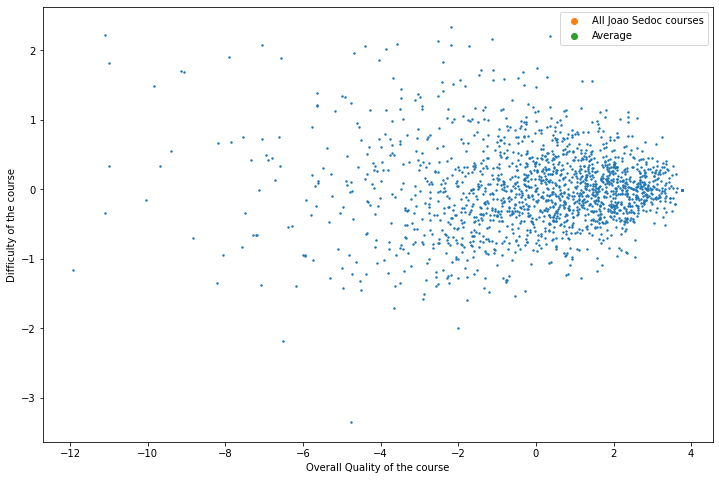

In [1228]:
findProfOn2DSpace("Joao Sedoc", sternPCA)

In [1206]:
cas.sort_values('qualityPCA', ascending=False)

,courseID,courseCode,courseSection,courseName,instructor,totalResponses,responseRate,OverallEvaluationCourse.,objectivesClearlyStated,courseWellOrganized,intellectuallyStimulating,EffectiveLearning,informative,challenging,increasedKnowledge,overallEvaluationInstructor.,conduciveToLearning.,helpfulFeedback,helpedMeLearn.,eencouragedParticipation.,facilitateDiscussion,openToQuestions,accessibleToStudents,inclusion,qualityPCA,difficultyPCA,sampleSize
374,2322,ECON-UA 10,002,Interm Microeconomics (Lecture),Olivier Gergaud,4,0.148,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.624936,1.154277,27.027027
4261,8701,SPAN-UA 50,005,Advanced Spanish (Lecture),Lorena Hernandez Ramirez,4,0.800,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.624936,1.154277,5.000000
602,7619,CLASS-UA 6,002,Intermediate Latin: Virgil (Lecture),Calloway Scott,3,0.300,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.624936,1.154277,10.000000
3019,23120,FREN-UA 632,001,French Novel and Society: The 19th Century (L...,Claudie Bernard,3,0.250,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.624936,1.154277,12.000000
4780,9647,CHEM-UA 911,001,Advanced Organic Chemistry (Lecture),Dirk Trauner,3,0.333,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.624936,1.154277,9.009009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,2065,BIOL-UA 30,001,Genetics (Lecture),Robert Rogers,3,0.300,2.3,2.3,1.7,2.7,2.0,2.3,3.0,2.3,1.7,1.7,1.7,2.0,1.7,2.0,1.7,2.3,2.7,-20.059374,-0.641477,10.000000
6183,9744,SPAN-UA 362,001,Is Spanish One Language? (Lecture),Sarah Pearce,4,0.333,1.3,1.5,1.3,2.0,1.8,1.8,3.0,2.0,1.8,2.0,1.3,1.5,3.8,1.8,3.5,2.0,3.3,-20.279443,-4.046432,12.012012
4421,5195,SCA-UA 234,001,Cultures & Economies: (Lecture),Lisa Duggan,3,0.231,2.3,2.3,2.3,2.7,2.3,3.3,4.0,3.0,1.0,1.3,2.3,1.3,1.0,1.7,1.0,2.3,1.0,-20.993025,4.095197,12.987013
4342,2638,ECON-UA 18,003,Statistics (P) (Lecture),Meixia Z Ruderman,7,0.350,1.4,2.3,1.4,2.1,1.6,2.3,3.4,2.6,1.4,1.4,1.9,1.4,1.4,1.4,2.0,2.9,1.4,-22.197987,0.579712,20.000000


In [1203]:
cas.groupby('courseCode').mean().sort_values('qualityPCA', ascending=True)

,courseID,totalResponses,responseRate,OverallEvaluationCourse.,objectivesClearlyStated,courseWellOrganized,intellectuallyStimulating,EffectiveLearning,informative,challenging,increasedKnowledge,overallEvaluationInstructor.,conduciveToLearning.,helpfulFeedback,helpedMeLearn.,eencouragedParticipation.,facilitateDiscussion,openToQuestions,accessibleToStudents,inclusion,qualityPCA,difficultyPCA,sampleSize
courseCode,,,,,,,,,,,,,,,,,,,,,,,
SPAN-UA 362,9744.0,4.0,0.3330,1.30,1.5,1.30,2.00,1.80,1.80,3.00,2.00,1.8,2.00,1.3,1.50,3.80,1.80,3.50,2.00,3.30,-20.279443,-4.046432,12.012012
FYSEM-UA 660,19655.0,14.0,0.7780,1.80,2.0,1.80,3.30,2.10,2.60,4.90,2.70,1.6,1.70,1.9,1.90,3.00,2.10,2.50,2.70,2.10,-18.300733,2.605609,17.994859
DRLIT-UA 623,22309.0,17.0,0.5480,2.60,2.4,2.10,2.90,2.80,3.00,3.00,3.10,2.4,2.90,2.4,2.80,3.80,3.10,3.40,2.20,3.20,-13.887540,-2.677934,31.021898
CLASS-UA 210,20559.5,9.0,0.5395,2.75,3.0,2.40,3.50,2.60,3.20,4.25,3.75,2.6,2.55,2.6,2.50,3.10,2.40,2.55,3.15,2.55,-13.481797,1.947778,16.499136
FYSEM-UA 656,19583.5,12.0,0.6475,2.60,2.6,2.35,3.15,2.55,3.15,3.50,3.40,2.6,2.75,2.3,2.55,3.15,2.55,3.60,3.90,2.80,-13.229414,-0.984268,18.504561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CRWRI-UA 863,8798.0,4.0,0.4440,5.00,5.0,5.00,5.00,5.00,5.00,5.00,5.00,5.0,5.00,5.0,5.00,5.00,5.00,5.00,5.00,5.00,4.624936,1.154277,9.009009
MEIS-UA 303,8424.0,3.0,0.4290,5.00,5.0,5.00,5.00,5.00,5.00,5.00,5.00,5.0,5.00,5.0,5.00,5.00,5.00,5.00,5.00,5.00,4.624936,1.154277,6.993007
FREN-UA 532,21232.0,3.0,0.3330,5.00,5.0,5.00,5.00,5.00,5.00,5.00,5.00,5.0,5.00,5.0,5.00,5.00,5.00,5.00,5.00,5.00,4.624936,1.154277,9.009009


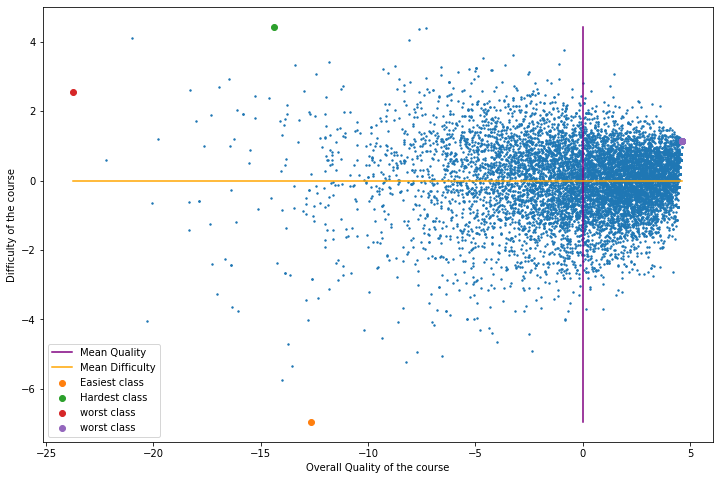

In [1202]:
schoolsPCA = casPCA

ylabel = "Difficulty of the course"
plt.scatter(-schoolsPCA[:, 0], -schoolsPCA[:, 1], s = 2)
plt.scatter(-schoolsPCA[cas[cas['difficultyPCA'] == min(-schoolsPCA[:, 1])].index, 0], -schoolsPCA[cas[cas['difficultyPCA'] == min(-schoolsPCA[:, 1])].index, 1], label = "Easiest class")
plt.scatter(-schoolsPCA[cas[cas['difficultyPCA'] == max(-schoolsPCA[:, 1])].index, 0], -schoolsPCA[cas[cas['difficultyPCA'] == max(-schoolsPCA[:, 1])].index, 1], label = "Hardest class")
plt.scatter(-schoolsPCA[cas[cas['qualityPCA'] == min(-schoolsPCA[:, 0])].index, 0], -schoolsPCA[cas[cas['qualityPCA'] == min(-schoolsPCA[:, 0])].index, 1], label = "worst class")
plt.scatter(-schoolsPCA[cas[cas['qualityPCA'] == max(-schoolsPCA[:, 0])].index, 0], -schoolsPCA[cas[cas['qualityPCA'] == max(-schoolsPCA[:, 0])].index, 1], label = "worst class")
#plt.scatter(-schoolsPCA[temp, 0].mean(), -schoolsPCA[temp, 1].mean(), label = "Average")
plt.plot([cas.qualityPCA.mean()] * 2, [cas.difficultyPCA.min(), cas.difficultyPCA.max()], c = 'purple', label = 'Mean Quality')
plt.plot([cas.qualityPCA.min(), cas.qualityPCA.max()], [cas.difficultyPCA.mean()]*2, c = 'orange', label = 'Mean Difficulty')
plt.xlabel("Overall Quality of the course")
plt.ylabel(ylabel)
plt.legend();

141     Algebra and Calculus  (Lecture)
142     Algebra and Calculus  (Lecture)
143     Algebra and Calculus  (Lecture)
427     Algebra and Calculus  (Lecture)
428     Algebra and Calculus  (Lecture)
429     Algebra and Calculus  (Lecture)
1284    Algebra and Calculus  (Lecture)
2064    Algebra and Calculus  (Lecture)
2065    Algebra and Calculus  (Lecture)
2066    Algebra and Calculus  (Lecture)
3856    Algebra and Calculus  (Lecture)
4378    Algebra and Calculus  (Lecture)
4379    Algebra and Calculus  (Lecture)
4380    Algebra and Calculus  (Lecture)
5237    Algebra and Calculus  (Lecture)
5238    Algebra and Calculus  (Lecture)
5239    Algebra and Calculus  (Lecture)
5829    Algebra and Calculus  (Lecture)
5830    Algebra and Calculus  (Lecture)
5831    Algebra and Calculus  (Lecture)
6572    Algebra and Calculus  (Lecture)
6573    Algebra and Calculus  (Lecture)
6574    Algebra and Calculus  (Lecture)
7715    Algebra and Calculus  (Lecture)
7716    Algebra and Calculus  (Lecture)


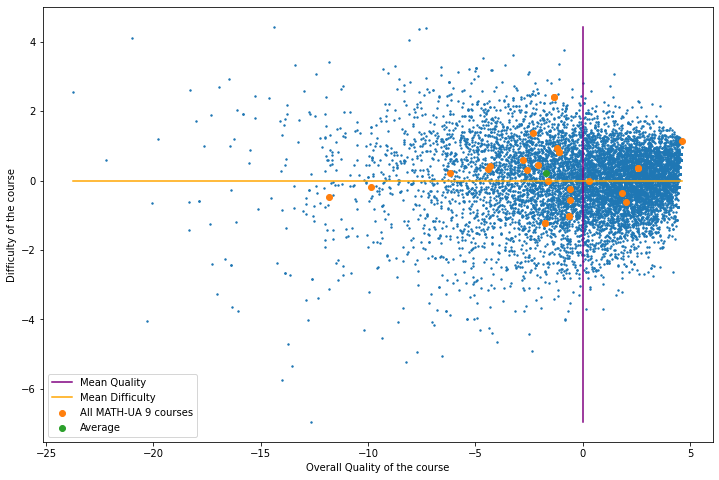

In [1207]:
findClassCodesOn2DSpace('MATH-UA 9', casPCA)

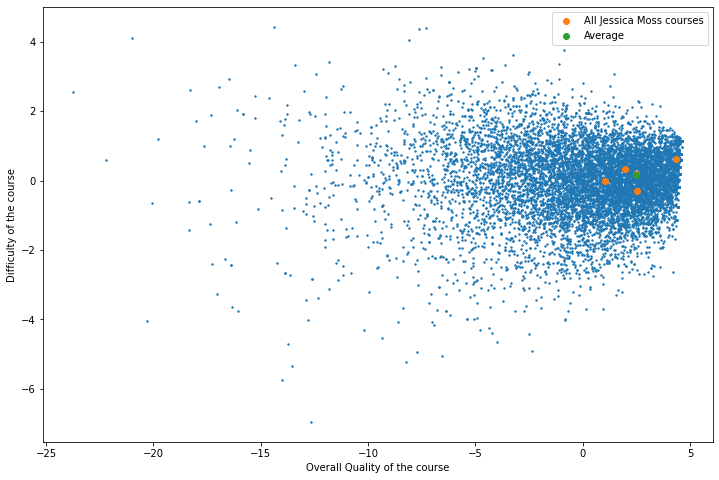

In [559]:
findProfOn2DSpace('Jessica Moss', casPCA)

# Stern PCA

[0.83372719 0.88433641 0.92873625 0.96106116 0.97801549 0.99185865
 1.        ]




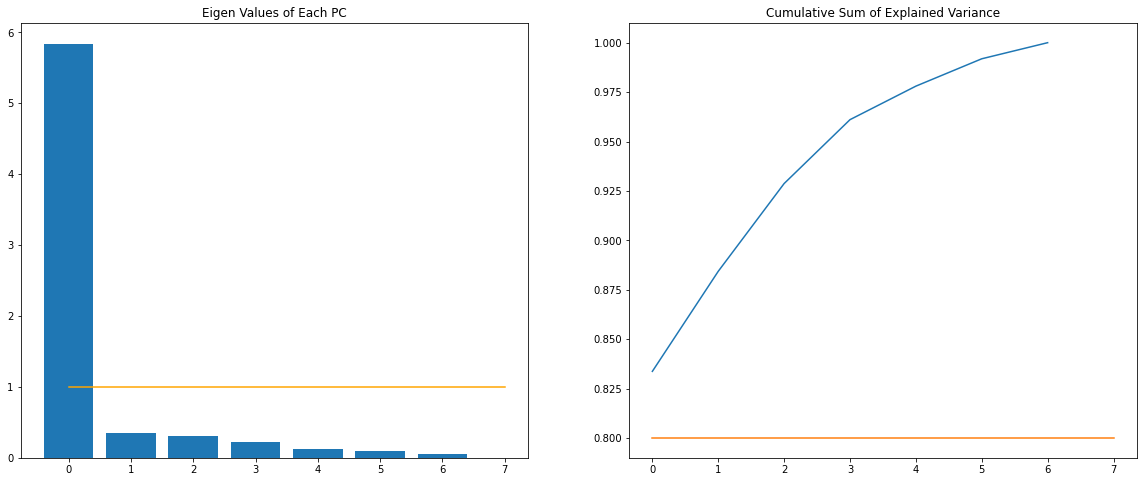

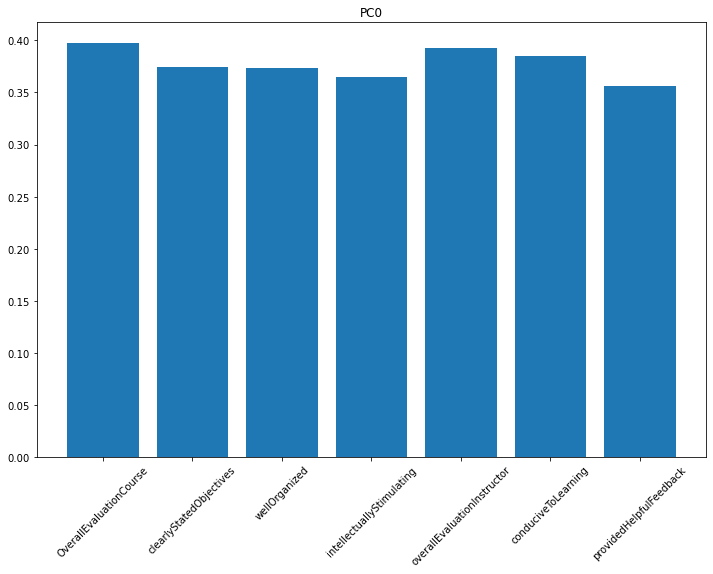

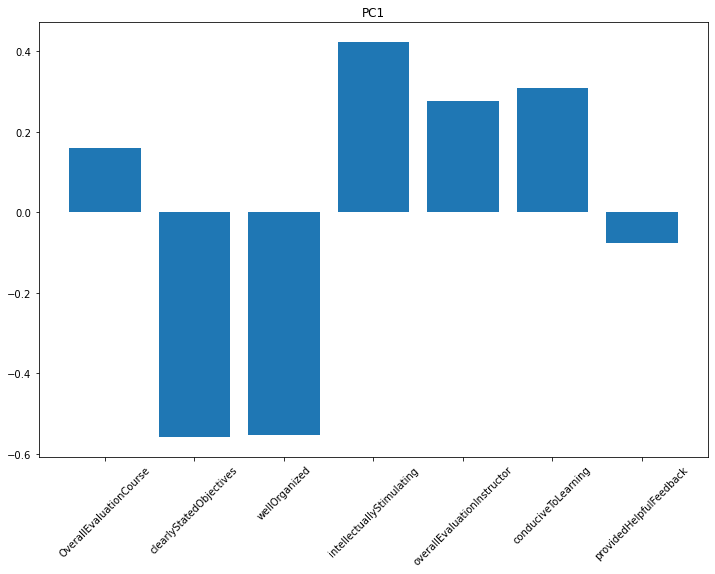

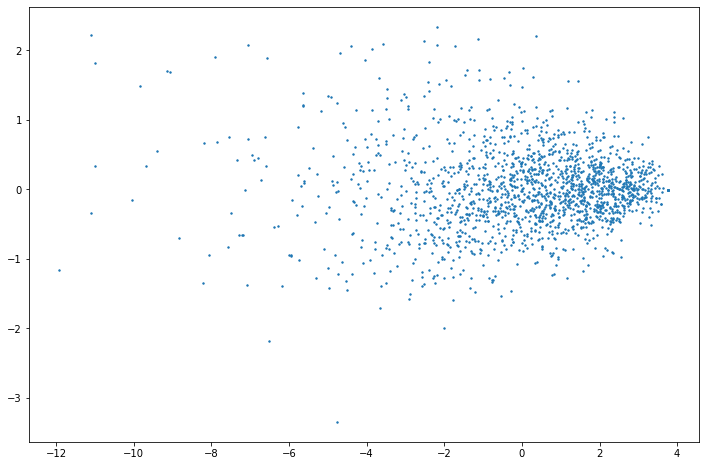

In [560]:
sternPCA, _ = performPCA(Xstern)

Because stern has much fewer features (7 compared to 17 of cas), it's expected that one PC would explain more variance    
PC1: overall quality    
PC2: organization (is well organized?)

We will also use the feature "intellectuallyStimulating" as a criteria for course selection

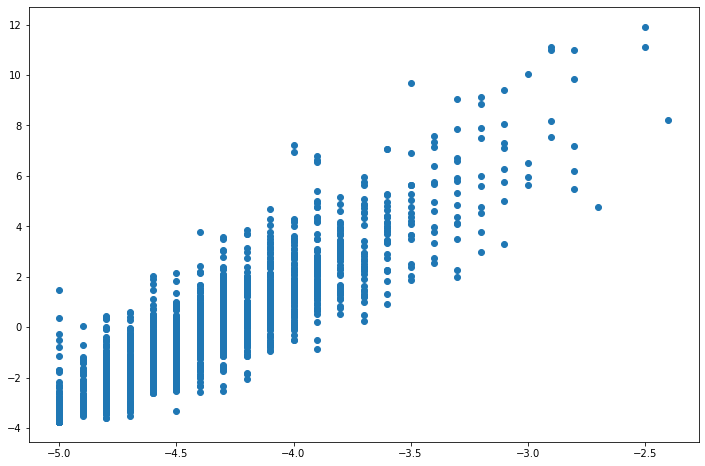

In [561]:
plt.scatter(-Xstern.intellectuallyStimulating, sternPCA[:, 0])

# "Prototpye" functions for this product    


## 1. `findCourseBasedOnDifficulty(difficulty)` "difficulty" takes discrete values for now (easy, average, hard) corresponding to the 0th-33rd-66rd percentiles



In [1208]:
def findCourseBasedOnDifficulty(difficulty, department = None):
    d = -casPCA[:, 1]
    diffPercentiles = np.percentile(-casPCA[:, 1], [0, 20, 40, 60, 80, 100])
    indices = np.argwhere((d >= diffPercentiles[difficulty]) & (d <= diffPercentiles[difficulty+1])).flatten()
    result = cas.iloc[indices]
    result['quality'] = -casPCA[indices, 0]
    if department:
        return result[result.courseCode.str.contains(str.upper(department))].sort_values('quality', ascending = False)#.drop('quality', axis = 1)
        
    return cas.iloc[indices]

In [1005]:
np.percentile(-casPCA[:, 1], [0, 33, 66, 100])

array([-6.95898792, -0.35737895,  0.44330923,  4.43536035])

In [750]:
def plotFindResults(df):
    plt.scatter(-casPCA[:, 0], -casPCA[:, 1], s =2)
    plt.scatter(-casPCA[df.index, 0], -casPCA[df.index, 1], label = 'All', c = 'rosybrown')
    plt.scatter(np.mean(-casPCA[df.index, 0]), np.mean(-casPCA[df.index, 1]), marker='P', label = "Average", c = 'fuchsia', s =100)
    
    plt.legend()

### Demo

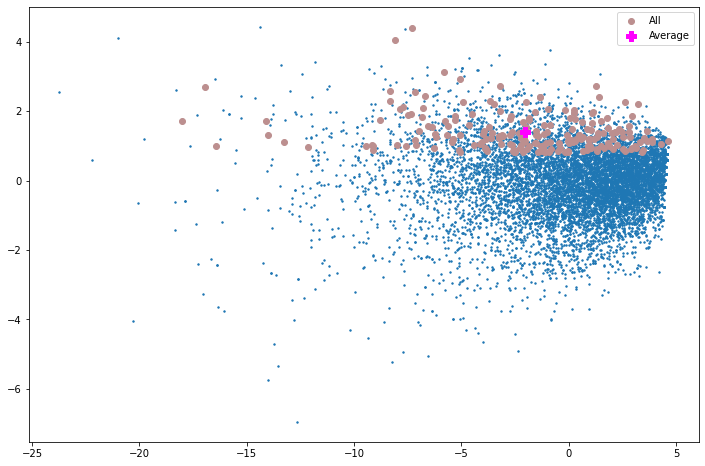

In [1211]:
diffDemo = findCourseBasedOnDifficulty(4, 'MATH')
diffDemo.head()
plotFindResults(diffDemo)

In [1003]:
print("Class rated difficult has an average \"Challenging\" rating of: %.3f" %  diffDemo.challenging.mean())
print("Average \"Challenging\" rating of all classes is: %.3f" % cas.challenging.mean())

Class rated difficult has an average "Challenging" rating of: 3.901
Average "Challenging" rating of all classes is: 4.297


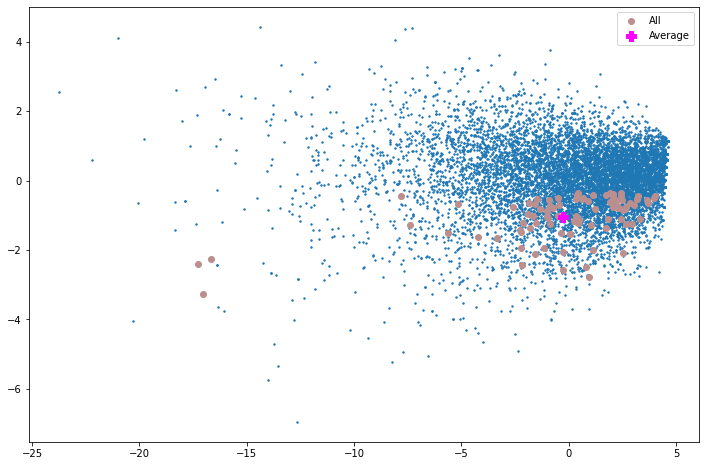

In [1004]:
# Orange is hard classes
plotFindResults(diffDemo)


### 2. `findCourseBasedOnQuality(quality)`   
`quality` also takes discrete values for now. As students probably won't purposely choose bad classes, we ask them to rate how much they care about quality, instead of choosing a quality    
0: don't care    
1: as long as it's not a terrible class I'm okay   
2: I want to take quality classes   
3: best classes

In [653]:
def findCourseBAsedOnQuality(quality, department = None):
    q = -casPCA[:, 0]
    diffPercentiles = np.percentile(-casPCA[:, 1], [0, 33, 66, 90, 100])
    indices = np.argwhere((q >= diffPercentiles[quality])).flatten()
    result = cas.iloc[indices]
    result['difficulty'] = -casPCA[indices, 1]
    if department:
        return result[result.courseCode.str.contains(department)].sort_values('difficulty', ascending = False)
    return cas.iloc[indices]

### Demo

In [654]:
qualityDemo = findCourseBAsedOnQuality(3, 'BIOL')
qualityDemo

,courseID,courseCode,courseSection,courseName,instructor,totalResponses,responseRate,OverallEvaluationCourse.,objectivesClearlyStated,courseWellOrganized,...,overallEvaluationInstructor.,conduciveToLearning.,helpfulFeedback,helpedMeLearn.,eencouragedParticipation.,facilitateDiscussion,openToQuestions,accessibleToStudents,inclusion,difficulty
6414,8823,BIOL-UA 103,001,Bioinformatics in Medicine and Biology (Lecture),Manpreet Katari,3,0.273,4.7,5.0,5.0,...,4.7,5.0,4.7,5.0,4.7,4.7,4.7,4.7,4.7,1.855983
284,9438,BIOL-UA 32,001,Gene Structure and Function (Lecture),"Suse Broyde, Lihua Wang",21,0.389,4.8,4.7,4.7,...,4.8,4.8,4.4,4.6,4.4,4.3,4.7,4.8,4.7,1.415059
6411,7567,BIOL-UA 44,001,Microbiology and Microbial Genomics (Lecture),Patrick Eichenberger,26,0.565,4.8,4.7,4.7,...,4.8,4.7,4.3,4.7,4.0,4.0,4.4,4.6,4.7,1.301004
4510,10447,BIOL-UA 140,001,Where the City Meets the Sea: Studies in Coast...,Mary Killilea,3,0.188,4.7,4.7,4.7,...,4.7,5.0,4.3,5.0,5.0,5.0,5.0,4.3,5.0,1.215045
8093,9408,BIOL-UA 995,001,Becoming a Scientist (Honors) (Lecture),Gloria Coruzzi,9,0.692,4.8,4.8,4.6,...,4.8,4.8,4.9,4.8,4.9,4.9,4.6,4.6,4.4,1.194704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3438,10311,BIOL-UA 63,001,Fundamentals of Ecology (Lecture),"Shaista Madad, Katie Schneider Paolantonio",22,0.579,4.7,4.8,4.7,...,4.8,4.8,4.5,4.7,4.9,4.8,4.9,4.7,4.8,-1.192194
7421,9160,BIOL-UA 124,001,Fundamentals of Bioinformatics (Lecture),Manpreet Katari,5,0.500,4.4,4.8,4.4,...,4.6,4.6,4.6,4.8,5.0,4.8,4.8,4.8,4.6,-1.197447
18,2508,BIOL-UA 12,001,Principles of Biology II (Lecture),Erin Morrison,17,0.810,4.5,4.7,4.5,...,4.8,4.8,4.8,4.6,4.9,4.6,4.8,4.9,4.6,-1.360602
306,8808,BIOL-UA 123,018,Principles of Biology Laboratory (Laboratory),Christopher Catalano,5,0.556,4.6,5.0,4.8,...,5.0,5.0,4.8,5.0,5.0,5.0,5.0,5.0,5.0,-1.396869


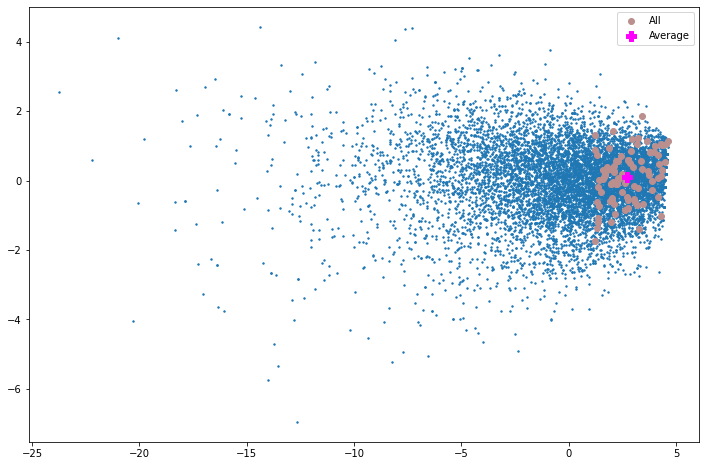

In [751]:
# Orange is hard classes
plotFindResults(qualityDemo)

# Load Data from RMP    
We plan to use the RMP data to create auxilary features

In [753]:
engine.execute('show tables').all()

[('CASCE',),
 ('RMPcommentsAndRatings',),
 ('RMPgeneralProfInfo',),
 ('SternCE',),
 ('stern_course_evaluations',)]

In [889]:
rmp = pd.read_sql('SELECT g.id, g.name, g.department, c.* FROM RMPgeneralProfInfo g INNER JOIN RMPcommentsAndRatings c ON g.id = c.profId', engine)

In [890]:
rmp

,id,name,department,profID,comment,sampleSize,qualityAvg,difficultyAvg,qualityStd,difficultyStd
0,2171,Julia Keefer,Film,2171,This class was mandatory. Prof Keefer is a nic...,8,4.500,2.833,1.118,0.687
1,18708,Alan Corns,Economics,18708,He was a great professor who had a tough subje...,8,2.833,4.500,1.280,0.764
2,18711,Hasia Diner,Social Science,18711,There is so much reading... The feedback on ou...,13,3.450,3.400,1.404,1.356
3,37951,Steve Hutkins,Interdisciplinary Studies,37951,I took this elective for fun $ am so happy I d...,9,4.500,2.000,0.463,0.756
4,41264,Tyler Volk,Science,41264,"LIFESCIENCE CORE REQUIREMENT: 22% EXAM 1, 22% ...",26,3.200,3.200,1.528,1.208
...,...,...,...,...,...,...,...,...,...,...
2851,1052652,Maitland Jones Jr.,Chemistry,1052652,Imagine reading an article from The New York T...,26,3.600,3.850,1.908,1.276
2852,1388150,Stefanos Geroulanos,History,1388150,Geroulanos expects a lot from his students but...,26,3.850,4.000,1.352,0.548
2853,2649675,George Benaroya,Marketing,2649675,One of my favorite classes at NYU. Professor B...,26,5.000,2.700,0.000,0.714
2854,2118628,Thomas Reynolds,Liberal Studies,2118628,shitttt\n\t\n10/10 recommend not taking this c...,8,1.333,4.500,0.745,0.500


## Sentiment Analysis

In [770]:
def getSentiment(text):
    endpoint = "https://api.us-south.natural-language-understanding.watson.cloud.ibm.com/instances/3d4468af-8ad0-4453-9535-72f90c9eb5c4/v1/analyze"

    # You can register and get your own credentials
    # The ones below have a quota of 1000 calls per day 
    # and can run out quickly if multiple people use these
    username = "apikey"
    password = "-OwF1ab-S1ekafX-ps_dSnaFE_Q0eYBf9wtTdcVV2x0B"

    parameters = {
        'features': 'emotion,sentiment',
        'version' : '2022-04-07',
        'text': text,
        'language' : 'en',
        # url = url_to_analyze, this is an alternative to sending the text
    }

    resp = requests.get(endpoint, params=parameters, auth=(username, password))

    return resp.json()

In [785]:
comments = rmp.comment.to_list()

In [788]:
#sents = []
#for comment in comments:
#    sents.append(getSentiment(comment))
    

In [877]:
emotions = []
sentiments = []
emoNone = []
sentNone = []
ii = 0
for sent in sents:
    #print(i)
    try:
        emo = sent['emotion']['document']['emotion']
        emotions.append(max(emo, key = emo.get))
    except:
        emotions.append(None)
        emoNone.append(ii)
        print("Emo None: ", ii)

    try:
        sent_ = sent['sentiment']['document']['score']
        sentiments.append(float(sent_))
    except:
        sentiments.append(None)
        sentNone.append(ii)
        print("sentiment none: ", ii)
        
    ii += 1

sentiment none:  794
sentiment none:  846
sentiment none:  874
sentiment none:  967
sentiment none:  970
sentiment none:  1095
sentiment none:  1152
sentiment none:  1211
sentiment none:  1294
sentiment none:  1307
sentiment none:  1320
sentiment none:  2458
Emo None:  2570
Emo None:  2639
Emo None:  2644
Emo None:  2670
Emo None:  2773
sentiment none:  2794


Fill in error values

In [878]:
for ii in emoNone:
    analysis = getSentiment(comments[ii])
    try:
        emo = analysis['emotion']['document']['emotion']
        emotions[ii] = max(emo, key = emo.get)
    except:
        print("No emotion analysis")


In [879]:
for ii in sentNone:
    analysis = getSentiment(comments[ii])
    try:
        sent_ = analysis['sentiment']['document']['score']
        sentiments[ii] = float(sent_)
    except:
        print()

In [891]:
rmp['sentiment'] = np.asarray(sentiments, float)
rmp['emotion'] = emotions
rmp['sentimentLabels'] = pd.cut(rmp.sentiment.values, [-1, -0.5, 0, 0.5,1], labels = ['Very Negative','Negative','Positive','Very Positive'])

In [892]:
rmp

,id,name,department,profID,comment,sampleSize,qualityAvg,difficultyAvg,qualityStd,difficultyStd,sentiment,emotion,sentimentLabels
0,2171,Julia Keefer,Film,2171,This class was mandatory. Prof Keefer is a nic...,8,4.500,2.833,1.118,0.687,0.839328,joy,Very Positive
1,18708,Alan Corns,Economics,18708,He was a great professor who had a tough subje...,8,2.833,4.500,1.280,0.764,0.378014,joy,Positive
2,18711,Hasia Diner,Social Science,18711,There is so much reading... The feedback on ou...,13,3.450,3.400,1.404,1.356,0.632160,joy,Very Positive
3,37951,Steve Hutkins,Interdisciplinary Studies,37951,I took this elective for fun $ am so happy I d...,9,4.500,2.000,0.463,0.756,0.822192,joy,Very Positive
4,41264,Tyler Volk,Science,41264,"LIFESCIENCE CORE REQUIREMENT: 22% EXAM 1, 22% ...",26,3.200,3.200,1.528,1.208,-0.306994,joy,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2851,1052652,Maitland Jones Jr.,Chemistry,1052652,Imagine reading an article from The New York T...,26,3.600,3.850,1.908,1.276,-0.284503,joy,Negative
2852,1388150,Stefanos Geroulanos,History,1388150,Geroulanos expects a lot from his students but...,26,3.850,4.000,1.352,0.548,0.536762,joy,Very Positive
2853,2649675,George Benaroya,Marketing,2649675,One of my favorite classes at NYU. Professor B...,26,5.000,2.700,0.000,0.714,0.857593,joy,Very Positive
2854,2118628,Thomas Reynolds,Liberal Studies,2118628,shitttt\n\t\n10/10 recommend not taking this c...,8,1.333,4.500,0.745,0.500,-0.711181,sadness,Very Negative


## How does RMP professor ratings relate to official course evalutaions?

In [1076]:
cas['sampleSize'] = cas.totalResponses / cas.responseRate
stern['sampleSize'] = stern.totalResponses / stern.responseRate

In [1077]:
casProfs = cas.groupby('instructor').mean()
casProfs.insert(0, 'instructor', casProfs.index)
casProfs = casProfs.reset_index(drop = True)
casProfs

,instructor,courseID,totalResponses,responseRate,OverallEvaluationCourse.,objectivesClearlyStated,courseWellOrganized,intellectuallyStimulating,EffectiveLearning,informative,challenging,increasedKnowledge,overallEvaluationInstructor.,conduciveToLearning.,helpfulFeedback,helpedMeLearn.,eencouragedParticipation.,facilitateDiscussion,openToQuestions,accessibleToStudents,inclusion,qualityPCA,difficultyPCA,sampleSize
0,Aaditya Rangan,9868.400000,12.600000,0.255600,4.180000,3.820,3.780000,4.420000,4.080000,4.400000,4.360000,4.440000,4.280000,4.360000,3.780000,4.22,4.080000,3.980000,4.540000,3.860000,4.260000,-2.403045,0.383033,47.384825
1,"Aakash Bhunia, Marc Lieberman",8028.000000,36.000000,0.434000,4.800000,4.900,4.900000,4.900000,4.700000,4.800000,4.600000,4.800000,4.900000,4.700000,4.500000,4.70,4.700000,4.400000,4.800000,4.700000,4.800000,2.527596,0.842347,82.949309
2,Aaron Reliford,9426.250000,18.000000,0.575250,4.775000,4.775,4.750000,4.750000,4.725000,4.825000,3.950000,4.775000,4.850000,4.900000,4.650000,4.70,4.900000,4.875000,4.900000,4.700000,4.850000,2.695862,-0.964308,31.257876
3,Abdul Nanji,10095.000000,5.500000,0.837500,4.500000,4.050,3.950000,4.750000,4.500000,4.600000,4.400000,4.850000,4.500000,4.700000,3.900000,4.70,4.900000,4.850000,4.750000,4.050000,4.450000,0.434549,0.010042,6.500000
4,Abhinav Tamaskar,3483.333333,6.666667,0.178667,3.066667,3.600,3.166667,3.966667,3.233333,3.533333,4.666667,4.100000,3.133333,3.233333,3.066667,3.10,3.433333,3.066667,3.800000,3.833333,3.733333,-8.227130,1.678987,35.375840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024,paola cerrito,2621.000000,6.500000,0.215000,3.850000,4.150,4.150000,4.350000,3.950000,4.350000,4.550000,4.350000,4.000000,4.150000,3.200000,3.65,3.950000,3.200000,4.350000,4.050000,4.150000,-3.648005,1.457930,31.057373
3025,"paola cerrito, Todd Disotell",19131.000000,13.000000,0.333000,4.200000,4.200,4.100000,4.700000,4.200000,4.600000,4.300000,4.400000,4.500000,4.100000,3.300000,3.90,3.800000,3.700000,4.500000,3.800000,4.200000,-2.476130,1.120883,39.039039
3026,skand goel,2282.000000,13.000000,0.295000,2.800000,2.900,3.200000,3.400000,2.800000,3.500000,4.800000,3.800000,2.900000,3.200000,3.400000,3.10,4.100000,2.800000,4.200000,4.200000,3.700000,-8.874774,0.597280,44.067797
3027,xtian w,2302.000000,3.000000,0.375000,5.000000,4.300,4.000000,4.300000,4.300000,4.300000,4.300000,4.300000,4.700000,4.700000,4.000000,4.30,4.300000,4.000000,4.300000,4.300000,5.000000,-0.536191,-0.237662,8.000000


In [1091]:
sternProfs = stern.groupby('instructor').mean()
sternProfs.insert(0, 'instructor', sternProfs.index)
sternProfs = sternProfs.reset_index(drop = True)
allProfs = sternProfs[['instructor', 'overallEvaluationInstructor', 'sampleSize', 'qualityPCA']].append(casProfs[['instructor','overallEvaluationInstructor.', 'sampleSize', 'qualityPCA']].rename(columns = {"overallEvaluationInstructor.":'overallEvaluationInstructor'}))

In [1092]:
rmpAndCE = pd.merge(allProfs, rmp, 'inner', left_on = 'instructor', right_on = 'name')

In [1094]:
rmpAndCE.corr()

,overallEvaluationInstructor,sampleSize_x,qualityPCA,id,profID,sampleSize_y,qualityAvg,difficultyAvg,qualityStd,difficultyStd,sentiment
overallEvaluationInstructor,1.000000,-0.236956,0.967574,0.090869,0.090869,-0.140811,0.573784,-0.241670,-0.339445,-0.138671,0.528012
sampleSize_x,-0.236956,1.000000,-0.300143,-0.084494,-0.084494,0.283017,-0.145193,-0.018846,0.195269,0.208176,-0.171666
qualityPCA,0.967574,-0.300143,1.000000,0.120561,0.120561,-0.169700,0.555391,-0.212705,-0.347160,-0.153639,0.503762
id,0.090869,-0.084494,0.120561,1.000000,1.000000,-0.577025,0.125373,-0.011128,-0.332422,-0.408355,0.058885
profID,0.090869,-0.084494,0.120561,1.000000,1.000000,-0.577025,0.125373,-0.011128,-0.332422,-0.408355,0.058885
sampleSize_y,-0.140811,0.283017,-0.169700,-0.577025,-0.577025,1.000000,-0.157903,0.162127,0.491057,0.545191,-0.113434
qualityAvg,0.573784,-0.145193,0.555391,0.125373,0.125373,-0.157903,1.000000,-0.399202,-0.559709,-0.223901,0.836887
difficultyAvg,-0.241670,-0.018846,-0.212705,-0.011128,-0.011128,0.162127,-0.399202,1.000000,0.315133,0.026473,-0.383668
qualityStd,-0.339445,0.195269,-0.347160,-0.332422,-0.332422,0.491057,-0.559709,0.315133,1.000000,0.566043,-0.396336
difficultyStd,-0.138671,0.208176,-0.153639,-0.408355,-0.408355,0.545191,-0.223901,0.026473,0.566043,1.000000,-0.141322


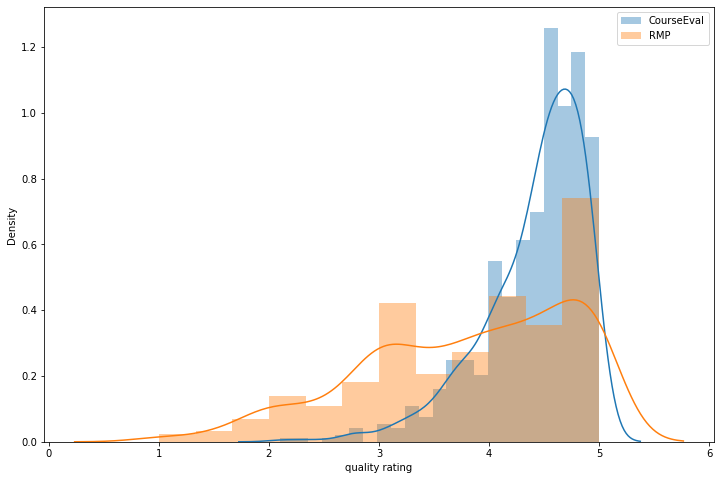

In [1066]:
sns.distplot(rmpAndCE['overallEvaluationInstructor'], label = "CourseEval")
sns.distplot(rmpAndCE['qualityAvg'], label = "RMP")
plt.xlabel("quality rating")
plt.legend()

<AxesSubplot:xlabel='variable', ylabel='value'>

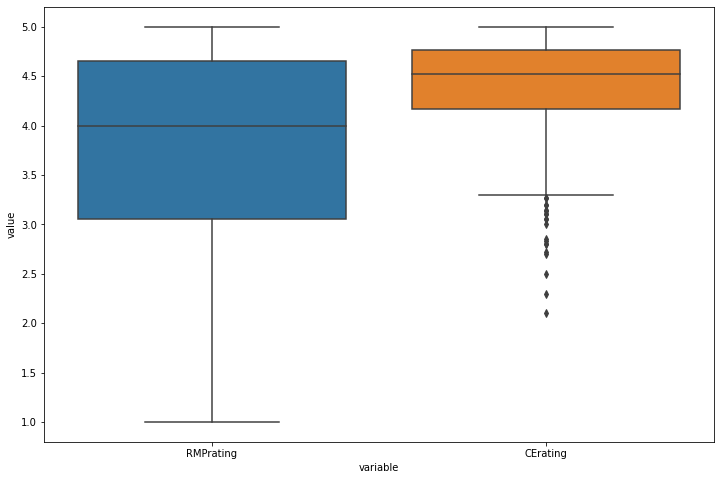

In [1065]:
mdf = pd.melt(rmpAndCE[['qualityAvg', 'overallEvaluationInstructor']].rename(columns ={"qualityAvg": "RMPrating", "overallEvaluationInstructor": "CErating"}))
sns.boxplot(x = "variable", y = 'value', data = mdf)

In [1224]:
cas

,courseID,courseCode,courseSection,courseName,instructor,totalResponses,responseRate,OverallEvaluationCourse.,objectivesClearlyStated,courseWellOrganized,intellectuallyStimulating,EffectiveLearning,informative,challenging,increasedKnowledge,overallEvaluationInstructor.,conduciveToLearning.,helpfulFeedback,helpedMeLearn.,eencouragedParticipation.,facilitateDiscussion,openToQuestions,accessibleToStudents,inclusion,qualityPCA,difficultyPCA,sampleSize
0,2752,ANTH-UA 1,001,"Culture, Power, Society (Lecture)",Murray Laura,5,0.278,4.8,4.4,4.6,4.4,4.2,4.4,4.4,4.4,4.6,4.4,4.4,4.4,4.6,4.2,4.6,4.4,4.4,-0.089243,0.123298,17.985612
1,2722,ANTH-UA 1,001,"Culture, Power, Society (Lecture)",Anisha Chadha,6,0.300,4.7,4.8,4.8,4.8,4.7,4.5,4.0,4.7,4.8,4.7,4.7,4.7,5.0,4.8,4.8,4.8,4.8,2.356668,-0.928563,20.000000
2,2798,ANTH-UA 1,060,"Culture, Power, Society (Lecture)",Anisha Chadha,6,0.300,4.7,4.8,4.8,4.8,4.7,4.5,4.0,4.7,4.8,4.7,4.7,4.7,5.0,4.8,4.8,4.8,4.8,2.356668,-0.928563,20.000000
3,2732,ANTH-UA 2,001,Human Evolution (Lecture),Alejandra Ortiz,4,0.286,3.8,4.0,4.3,4.0,3.5,4.5,4.3,4.3,4.3,4.0,4.5,4.3,3.3,2.8,3.5,4.3,4.3,-3.900977,1.301798,13.986014
4,2723,ANTH-UA 2,001,Human Evolution (Lecture),paola cerrito,6,0.171,3.7,3.7,4.0,4.0,3.8,4.0,4.2,3.8,3.7,3.7,3.0,3.0,3.8,3.0,3.8,4.0,3.7,-6.500822,0.840551,35.087719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9662,23356,DRLIT-UA 175,002,Topics: (Lecture),Eugenio Refini,17,0.850,4.6,4.8,4.8,4.4,4.5,4.6,4.4,4.8,5.0,4.9,4.9,4.9,4.9,4.9,4.9,5.0,4.9,2.787881,-0.579763,20.000000
9663,21366,DRLIT-UA 185,001,Topics: (Seminar),Yoon Jeong Oh,9,0.391,4.6,4.6,4.7,4.7,4.6,4.4,4.7,4.6,4.8,4.3,4.7,4.6,4.4,4.3,4.7,4.8,4.7,1.186910,0.839978,23.017903
9664,8269,EAST-UA 226,001,Introduction to Classical Chinese (Lecture),Shiqi Liao,3,0.300,5.0,5.0,4.3,5.0,4.3,4.7,4.7,4.7,4.7,4.7,4.7,4.7,4.3,4.3,4.0,4.3,4.3,0.986588,1.810650,10.000000
9665,10265,ENGL-UA 201,002,Reading as a Writer (Seminar),Marie-Christine Hyland,10,0.833,4.4,4.4,4.1,4.5,4.2,4.3,4.0,4.1,5.0,4.7,4.7,4.6,4.8,4.8,5.0,4.9,4.8,0.882117,-1.976866,12.004802


In [1226]:
pd.qcut(cas.qualityPCA, 5, labels = ['horrendous', 'bad','decent','good','excellent']).value_counts()

horrendous    1934
good          1934
bad           1933
decent        1933
excellent     1933
Name: qualityPCA, dtype: int64

In [1042]:
rmpAndCE.corr()['qualityAvg']['overallEvaluationInstructor']

0.5737838576908522

### rating of a professor is generally lower than that on CE!      
  
One average, 0.6 points lower

In [1221]:
(4.411854 - 3.808065) / 3.808065

0.15855532928140667

In [1218]:
pd.DataFrame({"platform": ["Course Evaluation", "RMP"], "meanSampleSize": [rmpAndCE['sampleSize_x'].mean(), rmpAndCE['sampleSize_y'].mean()],"meanRating": [rmpAndCE['overallEvaluationInstructor'].mean(), rmpAndCE['qualityAvg'].mean()], "stdRating": [rmpAndCE['overallEvaluationInstructor'].std(), rmpAndCE['qualityAvg'].std()]} )

,platform,meanSampleSize,meanRating,stdRating
0,Course Evaluation,39.378858,4.411854,0.466758
1,RMP,13.655360,3.808065,0.955104


Text(0.5, 1.0, 'Distribution of the difference between Course Evaluation and RMP sample size\n CE Mean: 39.379   RMP Mean: 13.655\nMean difference: 25.723')

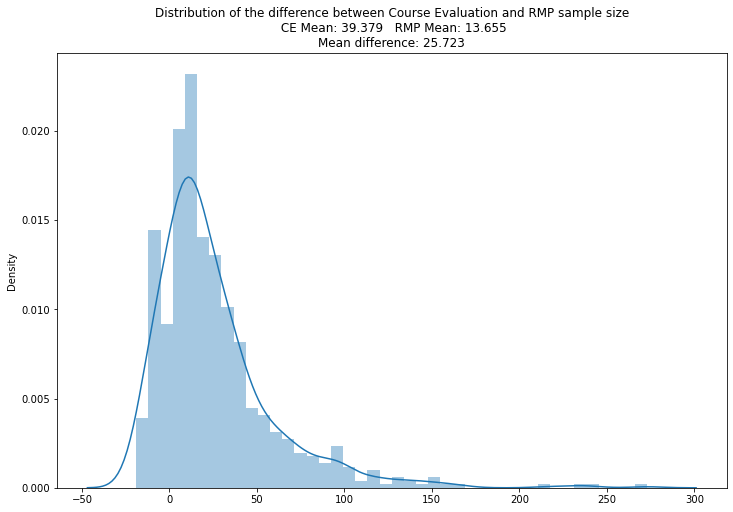

In [1128]:
sns.distplot(rmpAndCE.sampleSize_x - rmpAndCE.sampleSize_y)
plt.title("Distribution of the difference between Course Evaluation and RMP sample size\n CE Mean: %.3f   RMP Mean: %.3f\nMean difference: %.3f" % 
        (rmpAndCE.sampleSize_x.mean(), rmpAndCE.sampleSize_y.mean(), (rmpAndCE.sampleSize_x - rmpAndCE.sampleSize_y).mean()))

In [1217]:
(rmpAndCE.sampleSize_x - rmpAndCE.sampleSize_y).mean() / rmpAndCE.sampleSize_y.mean()

1.8837657242421808

In [1127]:
np.log(rmpAndCE.sampleSize_x).describe()

count    737.000000
mean       3.353714
std        0.775842
min        1.609438
25%        2.693871
50%        3.288314
75%        3.927440
max        5.700734
Name: sampleSize_x, dtype: float64

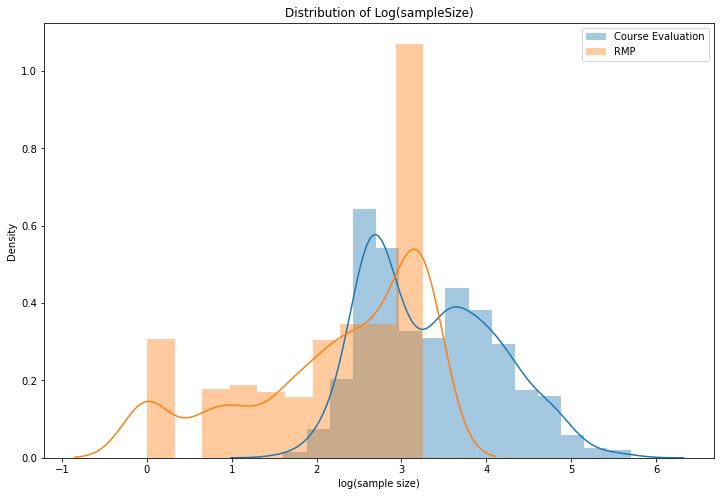

In [1120]:
sns.distplot(np.log(rmpAndCE.sampleSize_x), label = "Course Evaluation")
#sns.boxplot(x = "variable", y = "value", data= pd.melt(rmpAndCE[['sampleSize_x', 'sampleSize_y']]))
sns.distplot(np.log(rmpAndCE.sampleSize_y), label = "RMP")
plt.xlabel("log(sample size)")
plt.title("Distribution of Log(sampleSize)")
plt.legend()

In [1070]:
rmpAndCE['overallEvaluationInstructor'].std()

0.46675805775643175

In [1216]:
(rmpAndCE['qualityAvg'] - rmpAndCE['overallEvaluationInstructor']).mean()

-0.6037892880811779

Text(0.5, 1.0, 'r = 0.595')

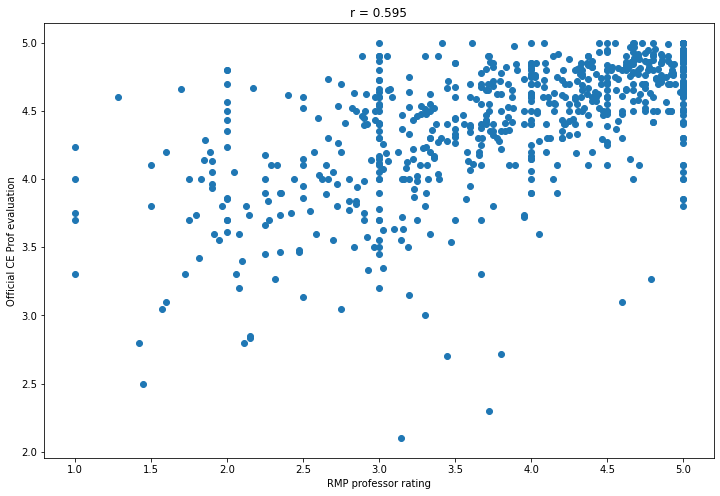

In [932]:
plt.scatter(rmpAndCE['qualityAvg'], rmpAndCE['overallEvaluationInstructor.'])
plt.xlabel("RMP professor rating")
plt.ylabel("Official CE Prof evaluation")
plt.title('r = %.3f' % rmpAndCE.corr()['qualityAvg']['overallEvaluationInstructor.'])

Text(0.5, 1.0, 'r = 0.419')

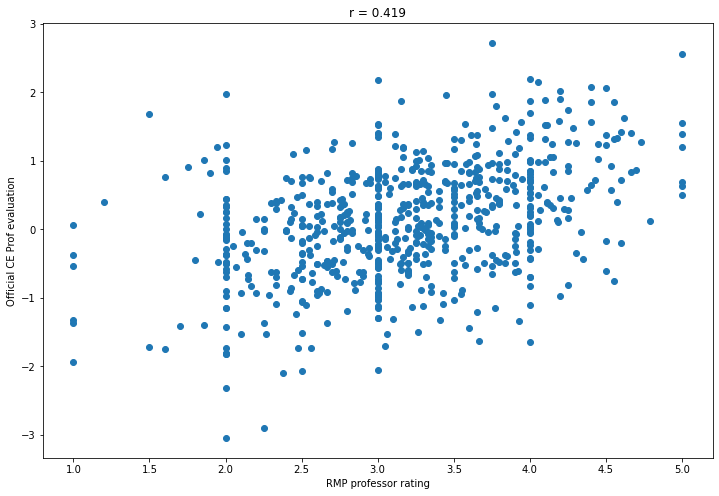

In [934]:
plt.scatter(rmpAndCE['difficultyAvg'], rmpAndCE['difficultyPCA'])
plt.xlabel("RMP professor rating")
plt.ylabel("Official CE Prof evaluation")
plt.title('r = %.3f' % rmpAndCE.corr()['difficultyAvg']['difficultyPCA'])

In [1214]:
rmpAndCE

,instructor,overallEvaluationInstructor,sampleSize_x,qualityPCA,id,name,department,profID,comment,sampleSize_y,qualityAvg,difficultyAvg,qualityStd,difficultyStd,sentiment,emotion,sentimentLabels
0,Adam Pincus,4.583333,49.319014,0.301682,2360451,Adam Pincus,Film amp Television,2360451,Applies his real-world producing experiences t...,3,3.333,4.000,0.943,0.816,0.443801,joy,Positive
1,Ajay Maindiratta,4.260000,45.611253,-0.404713,822331,Ajay Maindiratta,Accounting,822331,The lecture quality is poor because of heavy a...,10,2.875,3.000,1.474,1.225,-0.334022,joy,Negative
2,Aleksander Aleszczyk,4.833333,73.013088,2.182440,2577862,Aleksander Aleszczyk,Accounting,2577862,I love Prof. AAA. He explains things so well a...,5,5.000,3.250,0.000,0.433,0.739545,joy,Very Positive
3,Alex Dontoh,4.325000,52.500674,-0.251580,682726,Alex Dontoh,Accounting,682726,"Dontoh is great, really smart guy and interest...",9,4.214,2.714,0.881,0.881,0.749656,joy,Very Positive
4,Amal Shehata,4.836364,60.364696,2.221121,959478,Amal Shehata,Accounting,959478,Great professor in terms of how well she teach...,26,4.200,3.650,1.327,0.963,0.405951,joy,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,Zhihua An,4.281818,87.169137,-2.250538,1891201,Zhihua An,Chemistry,1891201,Dr.An is a very reasonable chemistry teacher. ...,26,3.450,3.600,1.532,0.860,0.427972,joy,Positive
733,Zhiyuan Zhang,3.600000,137.931034,-5.422343,2656225,Zhiyuan Zhang,Mathematics,2656225,"Doesn't explain things the clearest, but reall...",16,2.083,3.667,1.441,1.312,-0.510634,joy,Very Negative
734,Zlatko Bacic,3.266667,19.666316,-7.978063,8377,Zlatko Bacic,Chemistry,8377,Literally the worst professor i have ever had ...,14,2.318,3.909,1.248,1.240,-0.623708,sadness,Very Negative
735,Zsolt Pajor-Gyulai,4.100000,40.000000,-3.939327,2103674,Zsolt Pajor-Gyulai,Mathematics,2103674,He is very helpful and kind.\t\nThe subject of...,3,4.500,3.667,0.707,1.247,0.878876,joy,Very Positive
